In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

import torch
import numpy as np
import random
from time import time
from copy import deepcopy
from torch import nn
from torchsummary import summary
from torch.autograd import Variable
from torch.nn import functional as F 

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True

#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

MNIST_train = MNIST('./', download=True, transform = transforms.ToTensor(), train=True)
MNIST_test = MNIST('./', download=True, transform = transforms.ToTensor(), train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_indices_01 = []; train_indices_23 = []; train_indices_45 = []; train_indices_67 = []; train_indices_89 = []
test_indices_01 = []; test_indices_23 = []; test_indices_45 = []; test_indices_67 = []; test_indices_89 = []
for i in range(len(y_train)):
  if y_train[i] == 0 or y_train[i] == 1:
    train_indices_01.append(i)
  elif y_train[i] == 2 or y_train[i] == 3:
    train_indices_23.append(i)
  elif y_train[i] == 4 or y_train[i] == 5:
    train_indices_45.append(i)
  elif y_train[i] == 6 or y_train[i] == 7:
    train_indices_67.append(i)
  elif y_train[i] == 8 or y_train[i] == 9:
    train_indices_89.append(i)
  


for i in range(len(y_test)):
  if y_test[i] == 0 or y_test[i] == 1:
    test_indices_01.append(i)
  elif y_test[i] == 2 or y_test[i]== 3:
    test_indices_23.append(i)
  elif y_test[i] == 4 or y_test[i] == 5:
    test_indices_45.append(i)
  elif y_test[i] == 6 or y_test[i] == 7:
    test_indices_67.append(i)
  elif y_test[i] == 8 or y_test[i] == 9:
    test_indices_89.append(i)



X_train_01 = X_train[train_indices_01]
y_train_01 = y_train[train_indices_01]
X_test_01 = X_test[test_indices_01]
y_test_01 = y_test[test_indices_01]

X_train_23 = X_train[train_indices_23]
y_train_23 = y_train[train_indices_23]
X_test_23 = X_test[test_indices_23]
y_test_23 = y_test[test_indices_23]

X_train_45 = X_train[train_indices_45]
y_train_45 = y_train[train_indices_45]
X_test_45 = X_test[test_indices_45]
y_test_45 = y_test[test_indices_45]

X_train_67 = X_train[train_indices_67]
y_train_67 = y_train[train_indices_67]
X_test_67 = X_test[test_indices_67]
y_test_67 = y_test[test_indices_67]

X_train_89 = X_train[train_indices_89]
y_train_89 = y_train[train_indices_89]
X_test_89 = X_test[test_indices_89]
y_test_89 = y_test[test_indices_89]


X_test_01 = X_test_01.to(device)

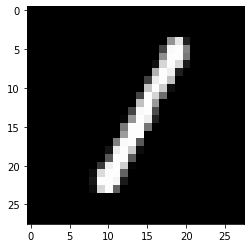

tensor(1)


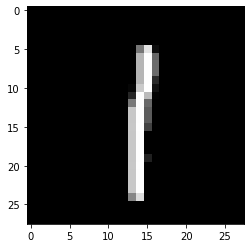

tensor(1)


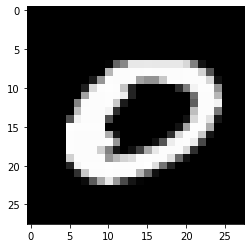

tensor(0)


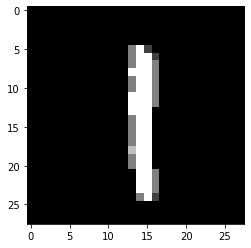

tensor(1)


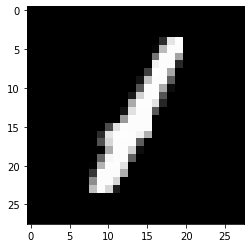

tensor(1)


In [ ]:
import matplotlib.pyplot as plt
def plot_num(x, y, count = 5):
    for i in np.random.permutation(len(x))[:count]:
        plt.imshow(x[i,:,:], cmap = 'gray')
        plt.show()
        print(y[i])
plot_num(X_train_01, y_train_01) 



In [ ]:
X_train = X_train.unsqueeze(1).float()/255
X_test = X_test.unsqueeze(1).float()/255

X_train_01 = X_train_01.unsqueeze(1).float()/255
X_test_01 = X_test_01.unsqueeze(1).float()/255

X_train_23 = X_train_23.unsqueeze(1).float()/255
X_test_23 = X_test_23.unsqueeze(1).float()/255

X_train_45 = X_train_45.unsqueeze(1).float()/255
X_test_45 = X_test_45.unsqueeze(1).float()/255

X_train_67 = X_train_67.unsqueeze(1).float()/255
X_test_67 = X_test_67.unsqueeze(1).float()/255

X_train_89 = X_train_89.unsqueeze(1).float()/255
X_test_89 = X_test_89.unsqueeze(1).float()/255

In [ ]:
class LeNet(torch.nn.Module):
  def __init__(self,activation = 'leaky relu', pooling = 'max', conv_size = 3, use_batch_norm = False, use_dropout = False):
    super(LeNet, self).__init__()
    self.conv_size = conv_size
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    if activation == 'relu':
      activation_function = torch.nn.ReLU()
    elif activation == 'tanh':
      activation_function = torch.nn.Tanh()
    elif activation == 'leaky relu':
        activation_function = torch.nn.LeakyReLU()
    else:
      raise NotImplementedError   

    if pooling == 'max':
      pooling_layer = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    elif pooling == 'avg':
      pooling_layer = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    else:
      raise NotImplementedError   
    
    if conv_size == 3:
      self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
      self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
    elif conv_size == 5:
      self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    else:
      raise NotImplementedError
    
    self.act1 = activation_function
    self.bn1 = torch.nn.BatchNorm2d(num_features=6)
    self.pool1 = pooling_layer
    self.dp1 = torch.nn.Dropout(p = 0.25) 

    if conv_size == 3:
      self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
      self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
    elif conv_size == 5:
      self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0)
    else:
      raise NotImplementedError

    self.act2 = activation_function
    self.bn2 = torch.nn.BatchNorm2d(num_features=16)
    self.pool2 = pooling_layer
    self.dp2 = torch.nn.Dropout(p=0.25) 

    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act3 = torch.nn.Tanh()
    self.dp3 = torch.nn.Dropout(p = 0.5) 

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.Tanh()
    self.dp4 = torch.nn.Dropout(p=0.5) 

    self.fc3 = torch.nn.Linear(84,10)
    self.act5 = torch.nn.Softmax()


  def forward(self,x):
    if self.conv_size == 3:
      x = self.conv1_1(x)
      x = self.conv1_2(x)
    elif self.conv_size == 5:
      x = self.conv1(x)

    x = self.act1(x)
    if self.use_batch_norm:
      x = self.bn1(x)
    x = self.pool1(x)
    if self.use_dropout:
      x = self.dp1(x)


    if self.conv_size == 3:
      x = self.conv2_1(x)
      x = self.conv2_2(x)
    elif self.conv_size == 5:
      x = self.conv2(x)
    
    x = self.act2(x)
    if self.use_batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)
    if self.use_dropout:
      x = self.dp2(x)

    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    if self.use_dropout:
      x = self.dp3(x)
    x = self.fc2(x)
    x = self.act4(x)
    if self.use_dropout:
      x = self.dp4(x)
    x = self.fc3(x)
    x = self.act5(x)
    
    x = x.to(device)

    return x

lenet = LeNet(use_batch_norm = True, use_dropout =True)
lenet = lenet.to(device)
loss = torch.nn.CrossEntropyLoss()
my_optimizer = torch.optim.Adam(lenet.parameters(), lr=4.0e-4)



def variable(t: torch.Tensor, use_cuda=True, **kwargs): 
    if torch.cuda.is_available() and use_cuda:         
        t = t.cuda()
    return Variable(t, **kwargs)


class EWC(object):
    def __init__(self, old_x, old_y = None, model = lenet):

        self.model = model
        self.old_x = old_x
        self.old_y = old_y
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._old_params = {}
        self._precision_matrices = self._diag_fisher() 

        for n, p in deepcopy(self.params).items():
            self._old_params[n] = variable(p.data)


    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items(): 
            p.data.zero_() 
            precision_matrices[n] = variable(p.data) 

        self.model.eval() 
        self.model.zero_grad() 
        self.old_x = variable(self.old_x) 
        output = self.model(self.old_x)
        output = output.to(device)
        loss = F.nll_loss(F.log_softmax(output, dim=1), self.old_y)
        loss.backward()

        for n, p in self.model.named_parameters():
            precision_matrices[n].data += p.grad.data ** 2 / len(self.old_x)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n].data * (p - self._old_params[n].data) ** 2
            loss += _loss.sum()
        return loss


def test_accuracy(x_test, y_test):
    x_test = x_test.to(device)
    test_preds = lenet.forward(x_test)
    test_preds = test_preds.to(device)
    y_test = y_test.to(device)
    accuracy = (test_preds.argmax(dim = 1) == y_test).float().mean().data.cpu()
    return accuracy



def normal_train(X_trains, y_trains, X_tests, y_tests, number, model = lenet, optimizer = my_optimizer, epochs = 10, batch_sizes = 64):
    model.train() 
    batch_size = batch_sizes
    test_accuracy_history = []
    best_accuracy = 0
    test_loss_history = []

    X_tests = X_tests.to(device)
    y_tests = y_tests.to(device)

    for epoch in range(epochs):
        order = np.random.permutation(len(X_trains))
        for start_index in range(0,len(X_trains), batch_size):
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_trains[batch_indexes].to(device)
            y_batch = y_trains[batch_indexes].to(device)

            X_batch, y_batch = variable(X_batch), variable(y_batch)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        test_preds = model.forward(X_tests)
        test_loss_history.append(loss(test_preds, y_tests).data.cpu())

        accuracy = (test_preds.argmax(dim = 1) == y_tests).float().mean().data.cpu()
        if number == 1:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
        elif number == 2:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23),)
        elif number == 3:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
        elif number == 4:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))
        elif number == 5:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))    
            print('accuracy on 89: ', test_accuracy(X_test_89,y_test_89))    

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = model.state_dict()
        test_accuracy_history.append(accuracy)
        print('total accuracy:',accuracy, '\n')
    model.load_state_dict(best_weights)


def ewc_train(X_trains, y_trains, X_tests, y_tests, old_x_test, old_y_test, number, 
              ewc: EWC, importance, epochs=0, model=lenet, optimizer=my_optimizer, batch_sizes=64):
    model.train()
    batch_size = batch_sizes
    test_accuracy_history = []
    test_loss_history = []
    best_accuracy = 0

    X_tests = X_tests.to(device)
    y_tests = y_tests.to(device)
    temp_epoch = 1
    while True:
        order = np.random.permutation(len(X_trains))
        for start_index in range(0,len(X_trains), batch_size):
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_trains[batch_indexes].to(device)
            y_batch = y_trains[batch_indexes].to(device)

            X_batch, y_batch = variable(X_batch), variable(y_batch)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss_value = loss(preds, y_batch) + importance * ewc.penalty(model)
            loss_value.backward()
            optimizer.step()
        
        test_preds = model.forward(X_tests)
        test_loss_history.append(loss(test_preds, y_tests).data.cpu())

        accuracy = (test_preds.argmax(dim = 1) == y_tests).float().mean().data.cpu()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = model.state_dict()
        test_accuracy_history.append(accuracy)
        old_accuracy = test_accuracy(old_x_test, old_y_test)
        print('accuracy on current task: ',accuracy)
        print('accuracy on old task: ', old_accuracy)
        if number == 1:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
        elif number == 2:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
        elif number == 3:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
        elif number == 4:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))
        elif number == 5:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))    
            print('accuracy on 89: ', test_accuracy(X_test_89,y_test_89))    

        temp_epoch += 1
        if temp_epoch <= epochs + 1:
            continue
        if temp_epoch == epochs + 10:
            break
        if (accuracy >= old_accuracy or (abs(accuracy - old_accuracy) <= 0.05 and number == 1) or abs(accuracy - old_accuracy) <= 0.03) and epochs == 0:
            break
    print('best accuracy =', best_accuracy)
    model.load_state_dict(best_weights)

def get_indices(x_train, percentage):
    order = np.random.permutation(len(x_train))
    #print('order type is ', type(order))
    return order[:(len(order)*percentage)//100]

def get_worst_ind(model, x_train, y_train, percentage):
    preds = model.forward(x_train.to(device))
    enough = (len(preds)*percentage)//100
    worst_inds = []
    for i in range(len(preds)):
        if preds[i].argmax() != y_train[i]:
            worst_inds.append(i)
    already_have = len(worst_inds)
    if already_have >= enough:
        return np.array(worst_inds[:enough])
    set_worst_inds = set(worst_inds)
    print(set_worst_inds)
    for i in np.random.permutation(len(x_train)):
        if already_have == enough: return np.array(worst_inds)
        if i not in set_worst_inds:
            worst_inds.append(i)
            already_have += 1



In [ ]:
%%time
normal_train(X_train_01,y_train_01,X_test_01,y_test_01, number=1) #обучаем классификатор на 01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy on 01:  tensor(1.)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(0.9986)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(1.)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(1.)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(0.9986) 

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(1.) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(1.) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

CPU times: user 16.5 s, sys: 303 ms, total: 16.8 s
Wall time: 17.5 s


In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=X_train_01, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=X_test_01, batch_size=batch_size, shuffle=False)

In [ ]:
def conv(in_channels, out_channels, kernel = 3, stride = 1, padding = 0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding = padding),
        nn.ReLU()
    )
def deconv(in_channels, out_channels, kernel = 3, stride = 1, padding = 0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding = padding),
        nn.Sigmoid()
    )

features = 32

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (3,24,24))

        self.feature_enc = conv(1,3,5)

        self.linear_enc = nn.Sequential(
            nn.Linear(3*24*24,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64, features*2),
        )
        self.linear_dec = nn.Sequential(
            nn.Linear(features, 64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,3*24*24),
        )
        self.feature_dec = deconv(3,1,5)

    def encode(self, x):
        x = self.feature_enc(x)
        x = self.flatten(x)
        x = self.linear_enc(x).view(-1,2,features)
        mu = x[:,0,:]
        logsigma = x[:,1,:]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        std = torch.exp(0.5*logsigma)
        
        if self.training:
            eps = torch.randn(features).to(device)
            latent_vector = mu + eps*std
            #print('latent_vector shape =', latent_vector.shape)
            return latent_vector
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        z = self.linear_dec(z)
        z = self.unflatten(z)
        reconstruction = self.feature_dec(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        x = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(x)    
        return mu, logsigma, reconstruction

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

In [ ]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.2)

In [ ]:
def vae_train(model, opt, scheduler, epochs, loss_fn, data_tr, data_val):
    x_val = next(iter(data_val))
    print("x_val shape =", x_val.shape)
    train_loss_history, val_loss_history = [], []
    best_val_loss = 1e9
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)
            opt.zero_grad()
            mu, logsigma, reconstruction = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma,  reconstruction)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        scheduler.step()
        toc = time()
        train_loss_history.append(avg_loss)
        print('train loss: %f' % avg_loss)

        model.eval()
        with torch.set_grad_enabled(False):
            val_mu, val_logsigma, val_reconstruction = model(x_val.to(device))
            val_loss = loss_fn(x_val.cpu(), val_mu.cpu(), val_logsigma.cpu(), val_reconstruction.cpu())
            val_loss_history.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()

        fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
        for j in range(5):
            ax[0][j].imshow(x_val[j].squeeze().cpu(), cmap ='gray')

        for j in range(5):
            ax[1][j].imshow(val_reconstruction[j].cpu().squeeze(), cmap = 'gray')

        plt.suptitle('%d / %d - val_loss: %f  ' % (epoch+1, epochs, val_loss)) 
        plt.show()
    plt_epochs = range(1, epochs+1)
    fig, ax = plt.subplots(1,2, sharex = True)

    #ax[0].plot(plt_epochs, train_loss_history, label = 'train loss')
    #ax[0].plot(plt_epochs, val_loss_history, label = 'val loss')
    #ax[0].legend()
    #ax[1].legend()
    #plt.show()
    
    model.load_state_dict(best_model_weights)


x_val shape = torch.Size([64, 1, 28, 28])
* Epoch 1/50
train loss: 16056.508789


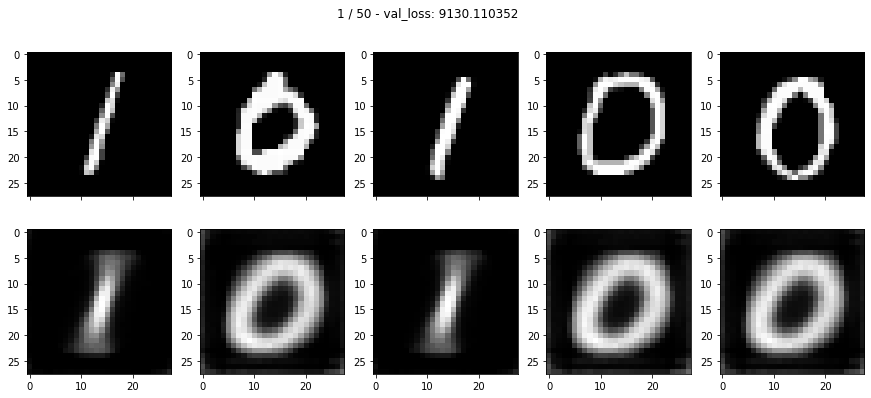

* Epoch 2/50
train loss: 9814.526367


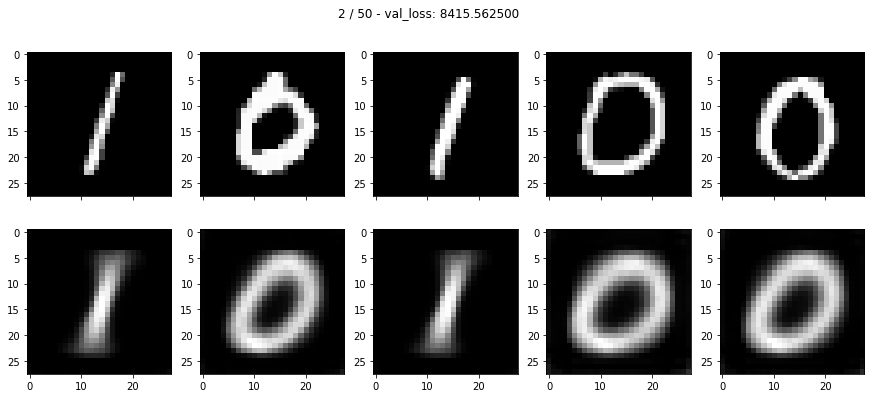

* Epoch 3/50
train loss: 9080.138672


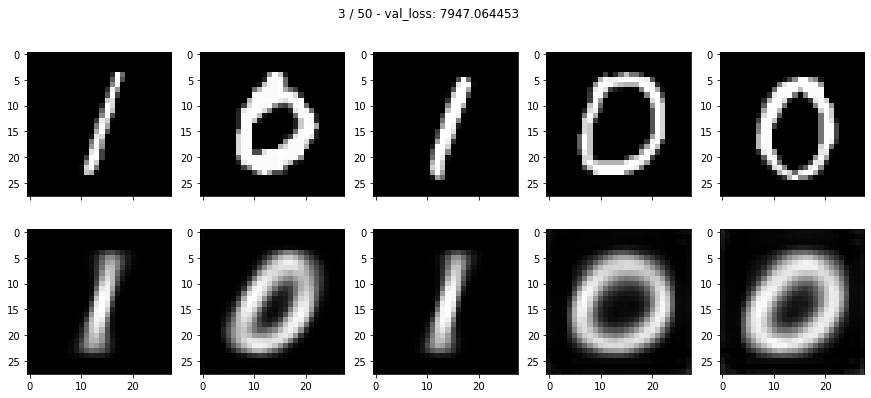

* Epoch 4/50
train loss: 8404.237305


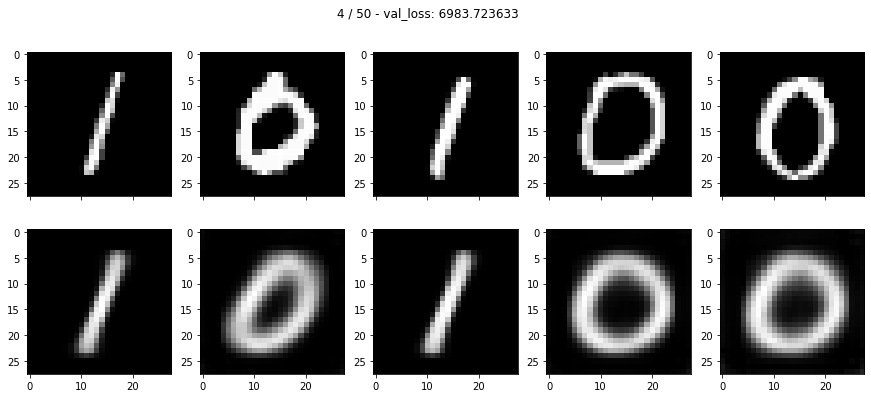

* Epoch 5/50
train loss: 7961.908691


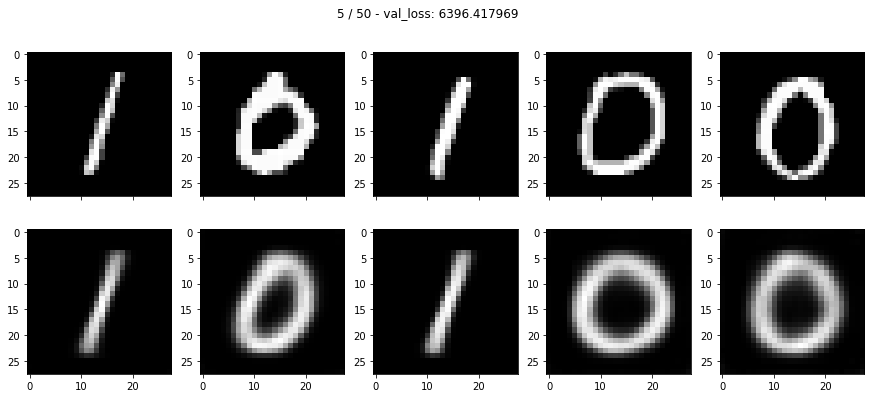

* Epoch 6/50
train loss: 7633.273926


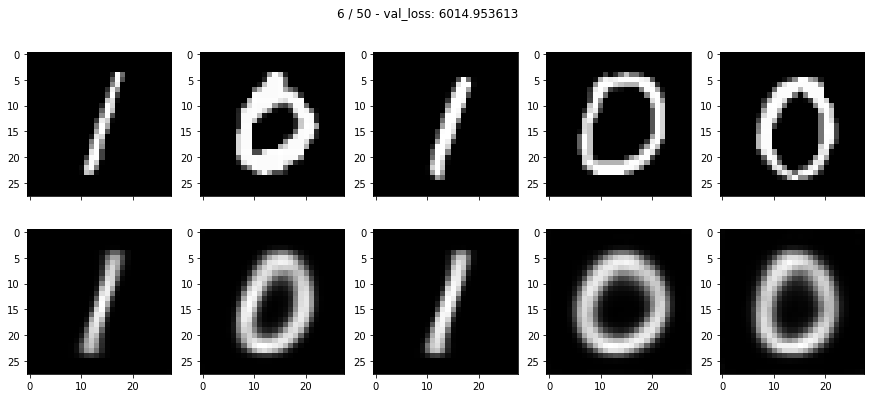

* Epoch 7/50
train loss: 7477.496582


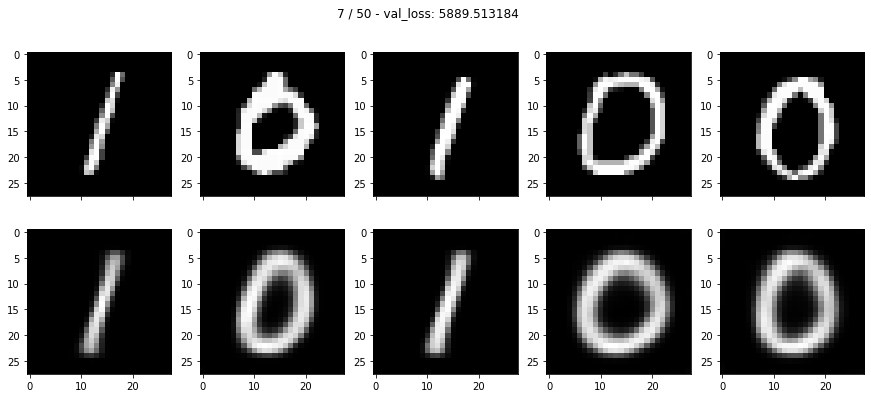

* Epoch 8/50
train loss: 7379.220703


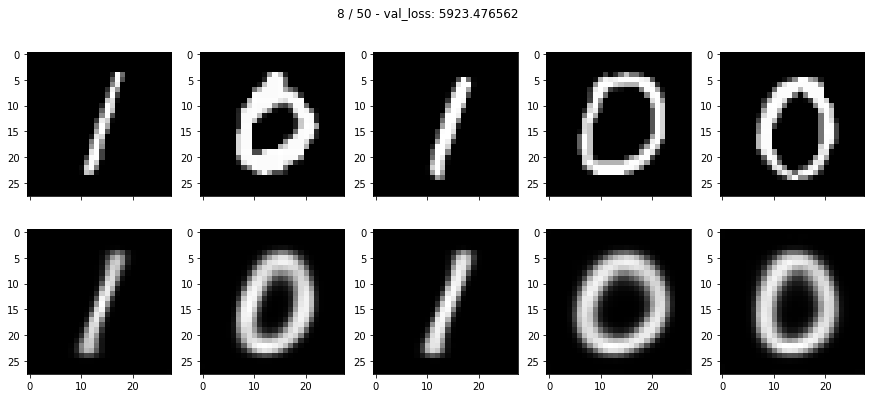

* Epoch 9/50
train loss: 7328.071289


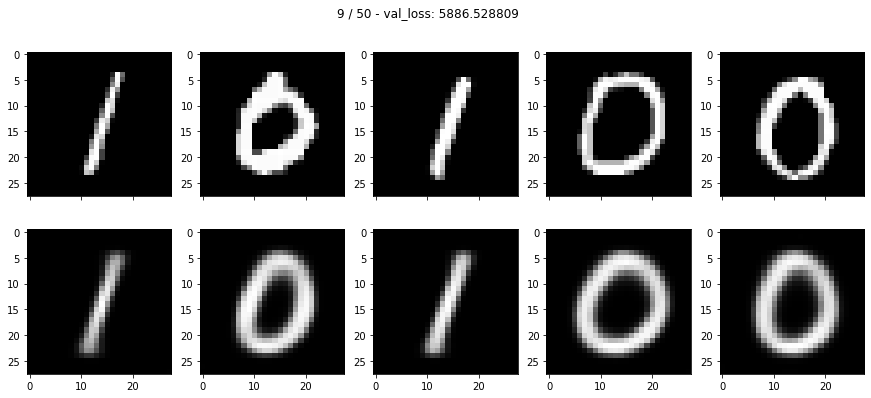

* Epoch 10/50
train loss: 7227.305176


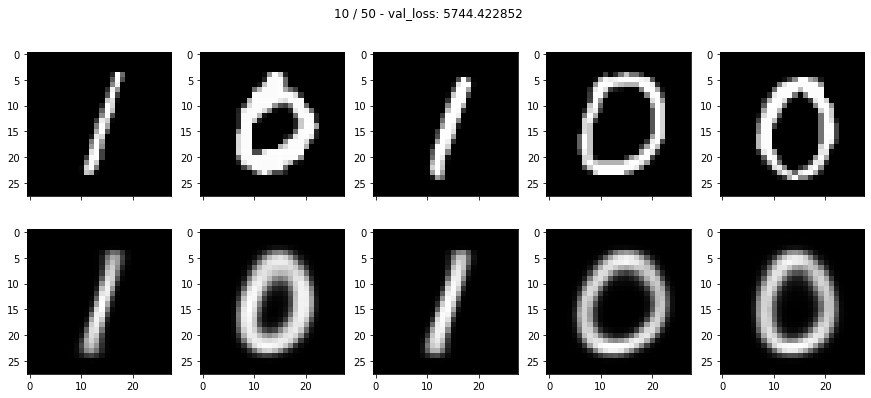

* Epoch 11/50
train loss: 7077.569824


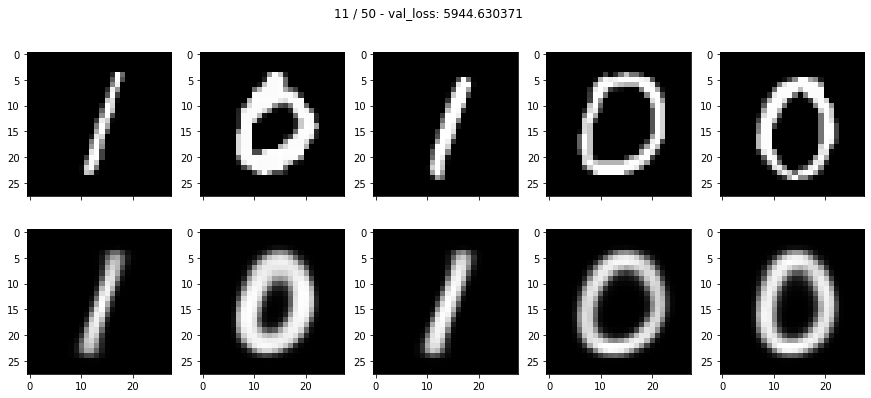

* Epoch 12/50
train loss: 7023.208008


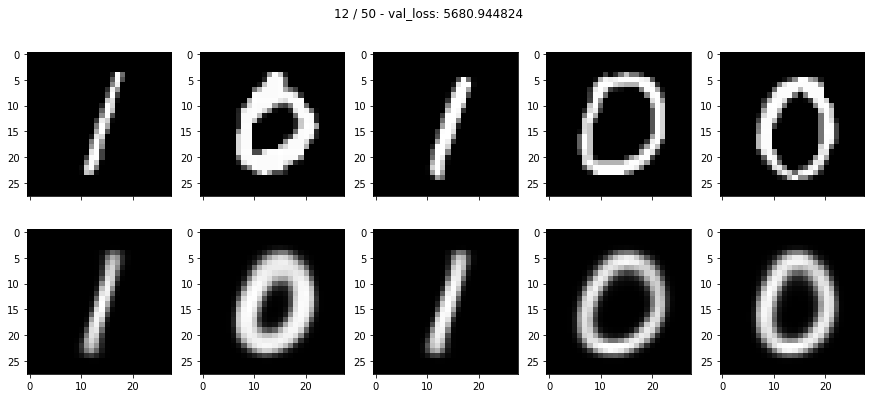

* Epoch 13/50
train loss: 6945.885742


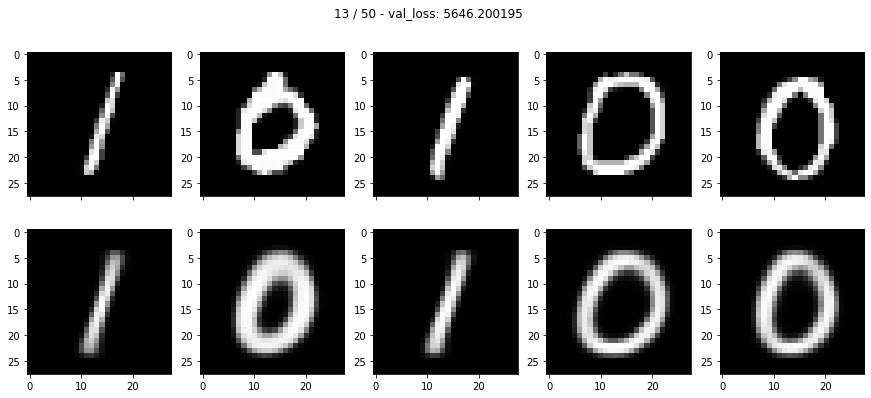

* Epoch 14/50
train loss: 6862.988770


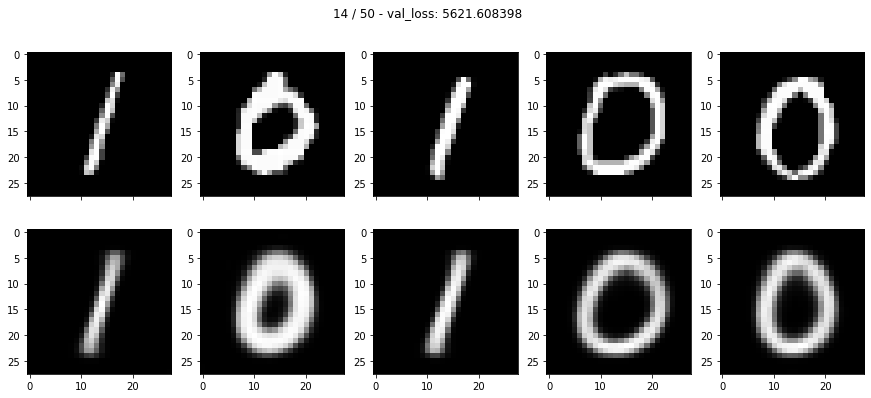

* Epoch 15/50
train loss: 6870.398438


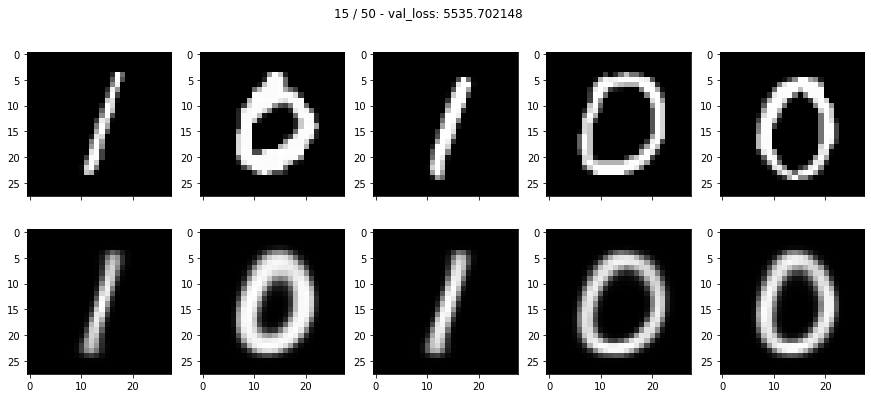

* Epoch 16/50
train loss: 6849.352051


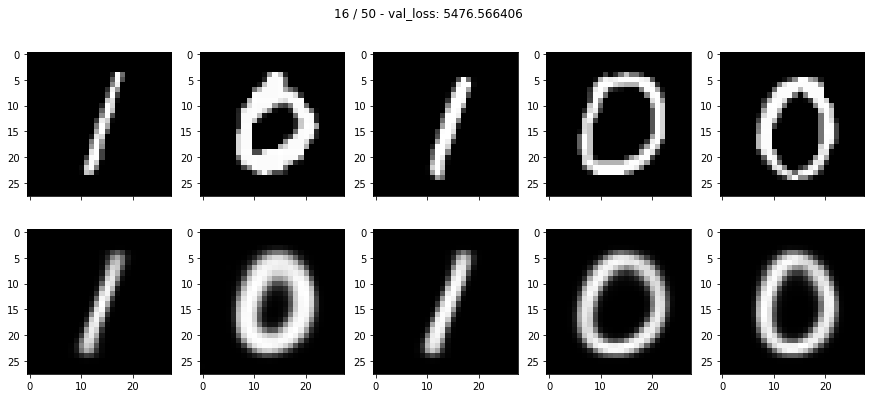

* Epoch 17/50
train loss: 6754.055176


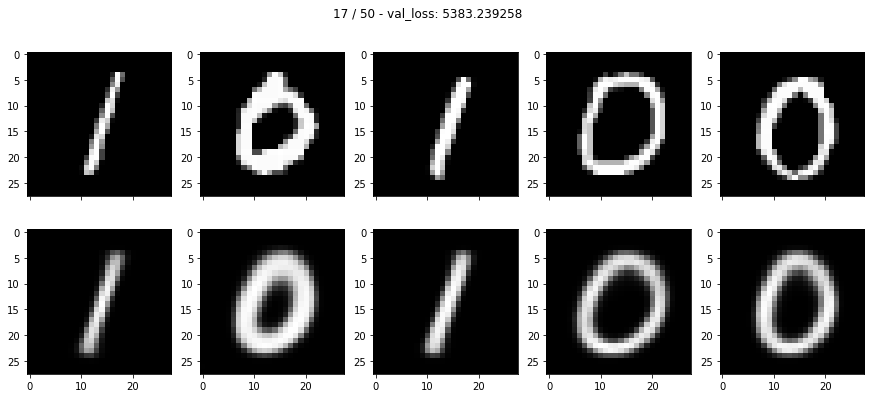

* Epoch 18/50
train loss: 6716.149414


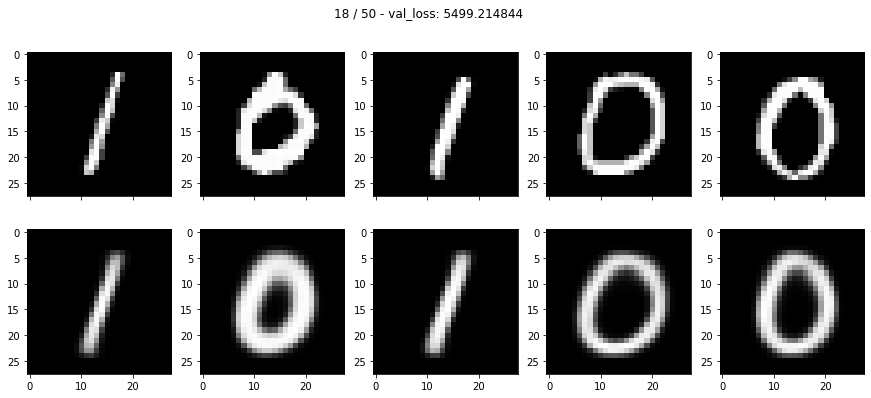

* Epoch 19/50
train loss: 6664.414062


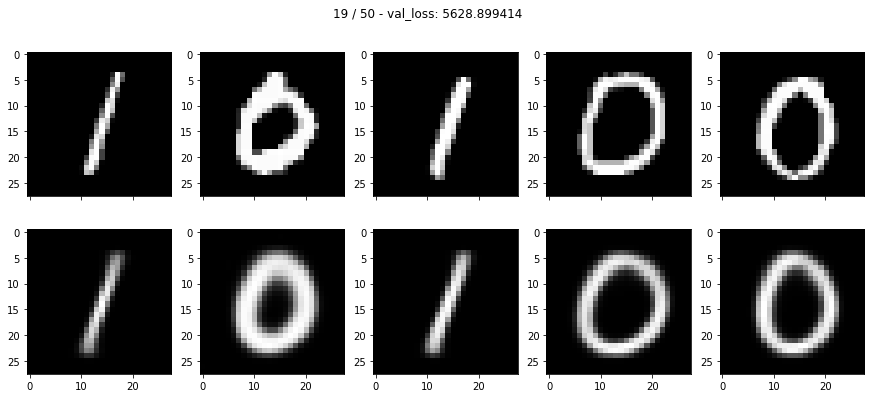

* Epoch 20/50
train loss: 6637.532715


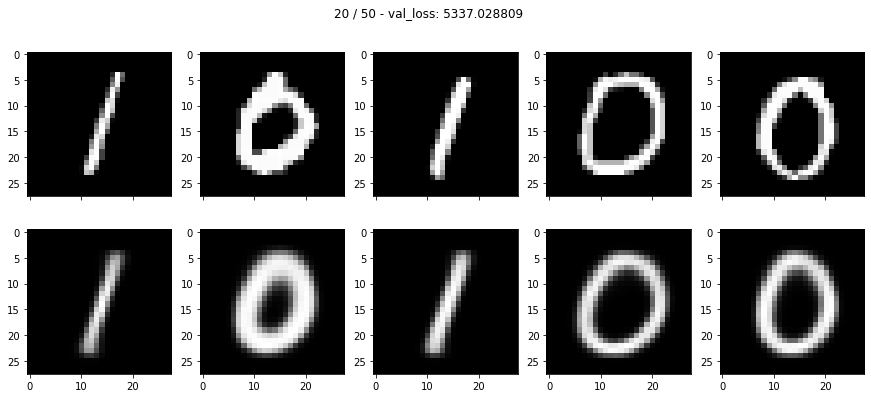

* Epoch 21/50
train loss: 6616.213867


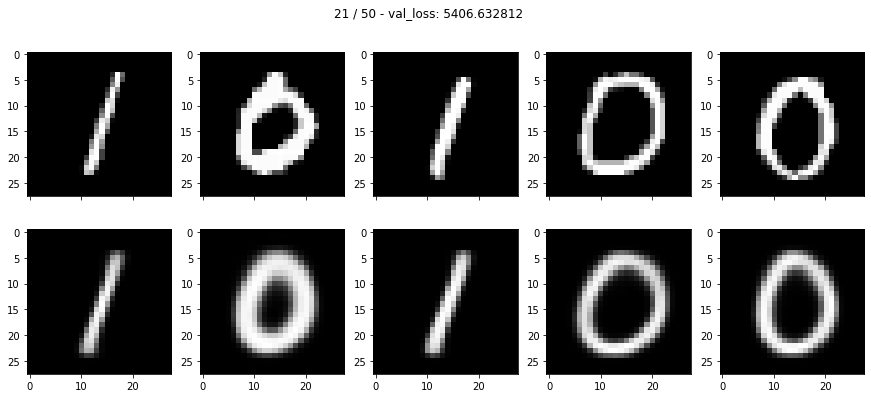

* Epoch 22/50
train loss: 6583.802246


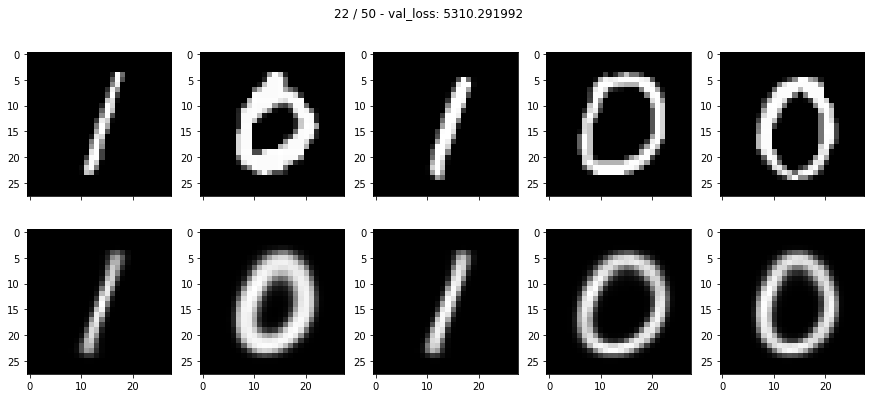

* Epoch 23/50
train loss: 6579.836426


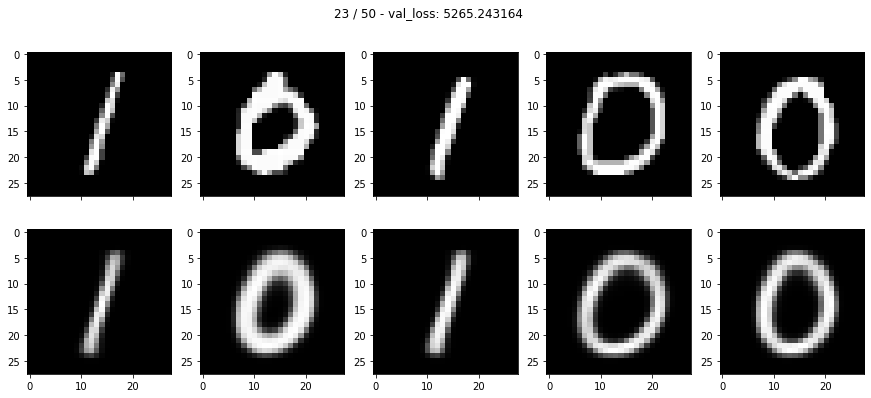

* Epoch 24/50
train loss: 6502.542480


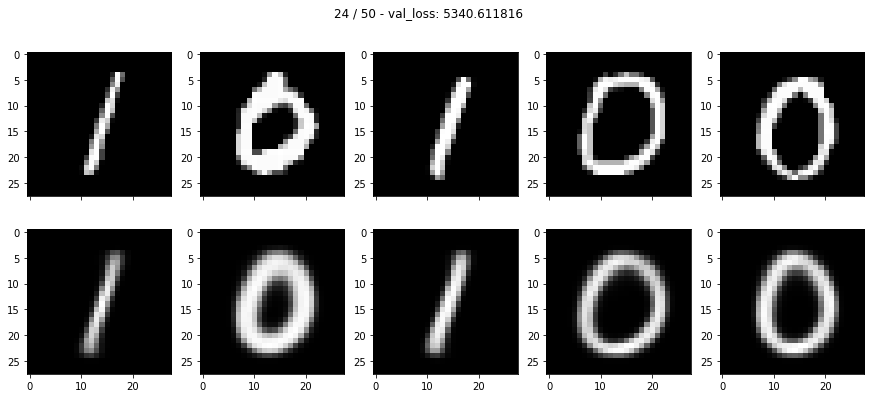

* Epoch 25/50
train loss: 6486.916504


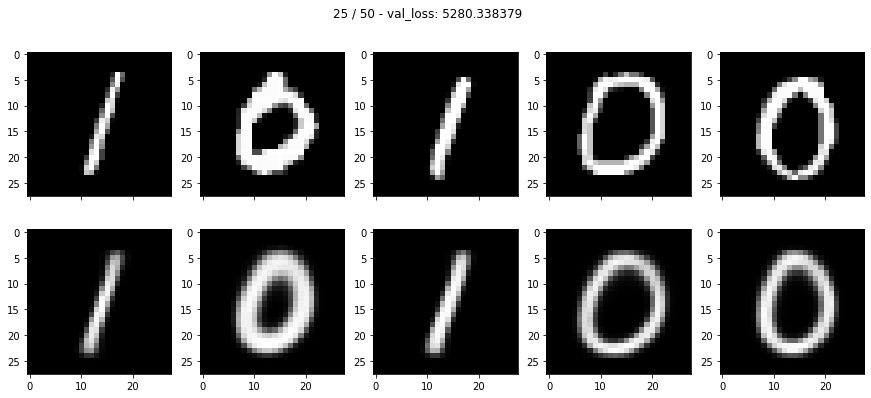

* Epoch 26/50
train loss: 6426.391602


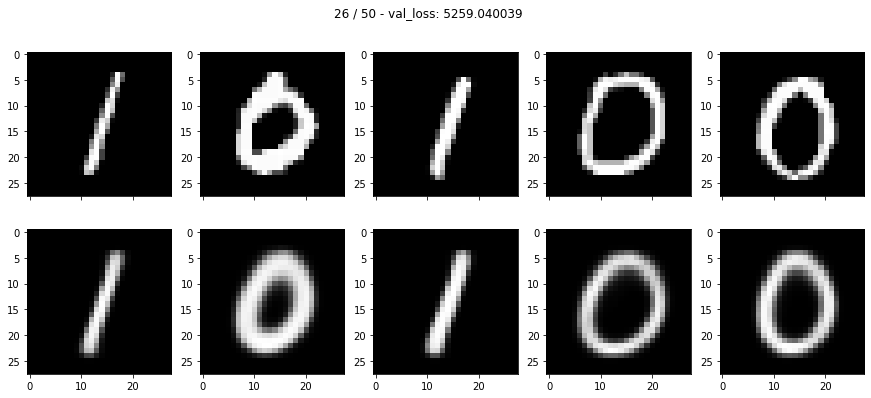

* Epoch 27/50
train loss: 6376.721191


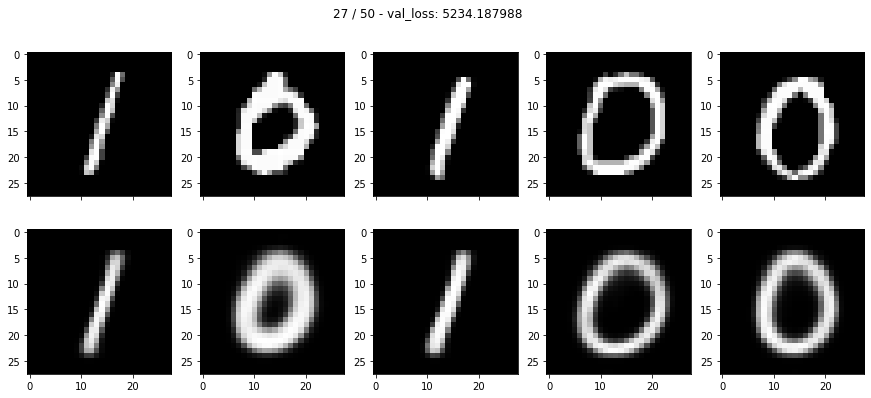

* Epoch 28/50
train loss: 6351.595703


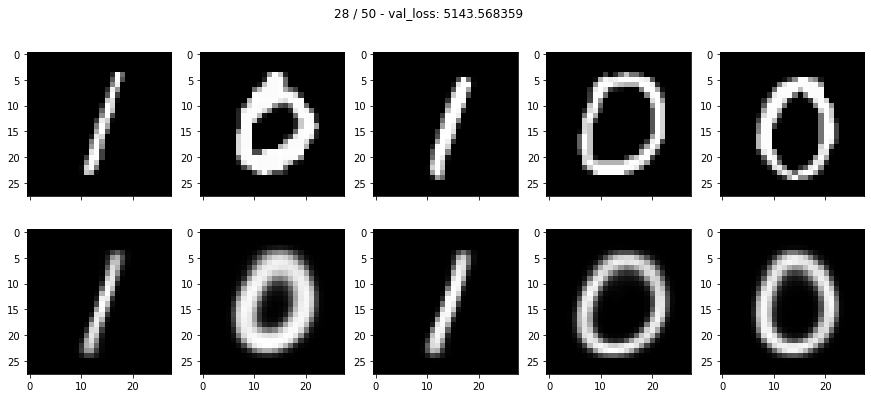

* Epoch 29/50
train loss: 6264.256348


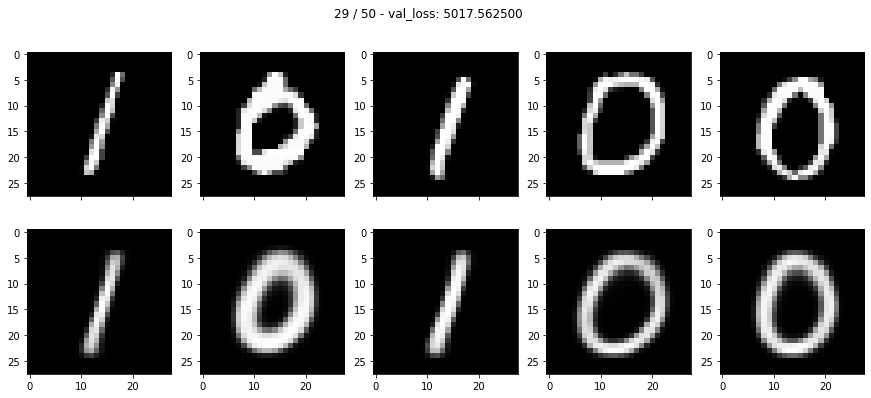

* Epoch 30/50
train loss: 6182.477051


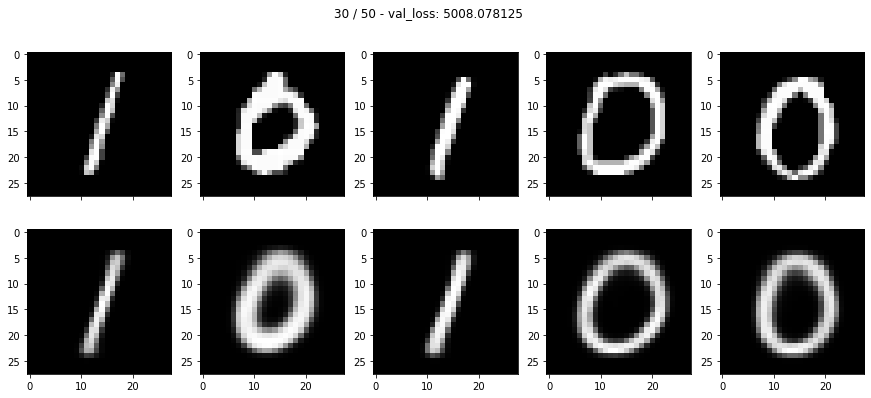

* Epoch 31/50
train loss: 6156.758789


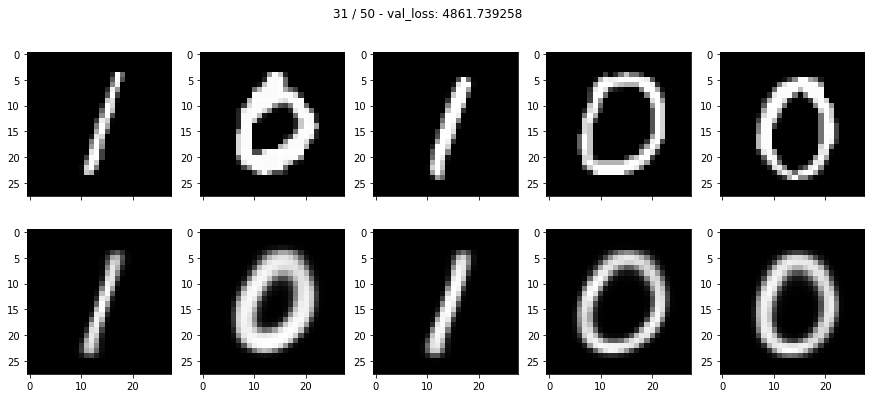

* Epoch 32/50
train loss: 6100.975098


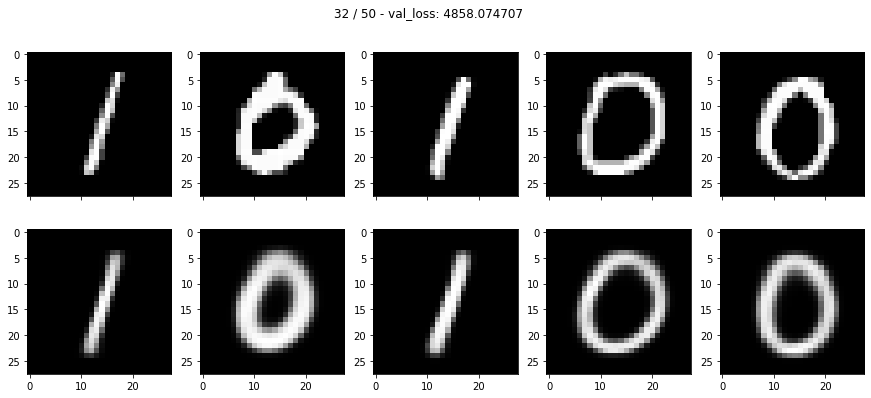

* Epoch 33/50
train loss: 6060.834473


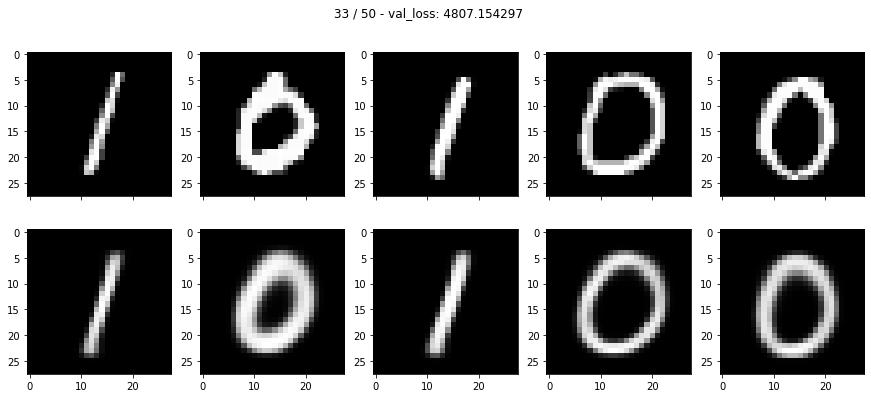

* Epoch 34/50
train loss: 6006.428711


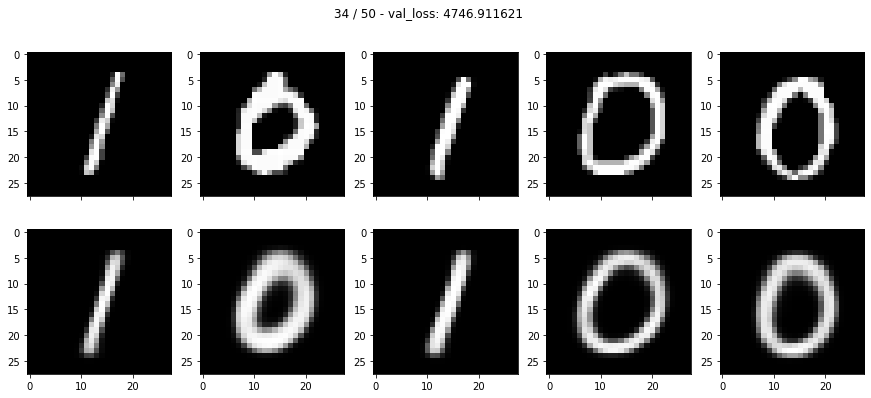

* Epoch 35/50
train loss: 5941.989258


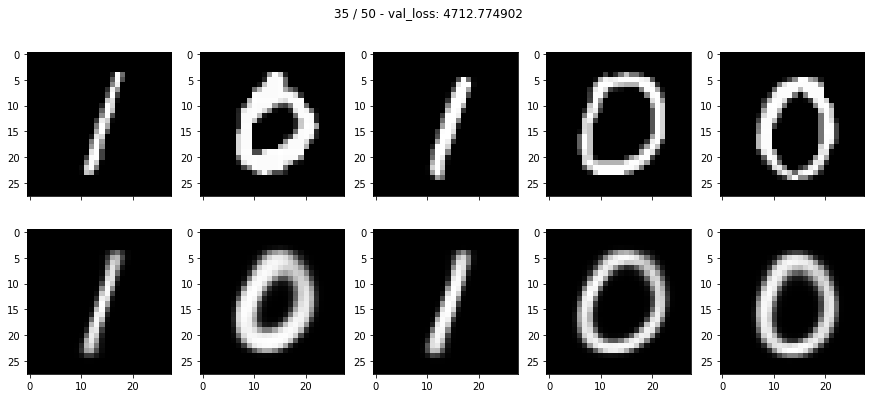

* Epoch 36/50
train loss: 5899.009766


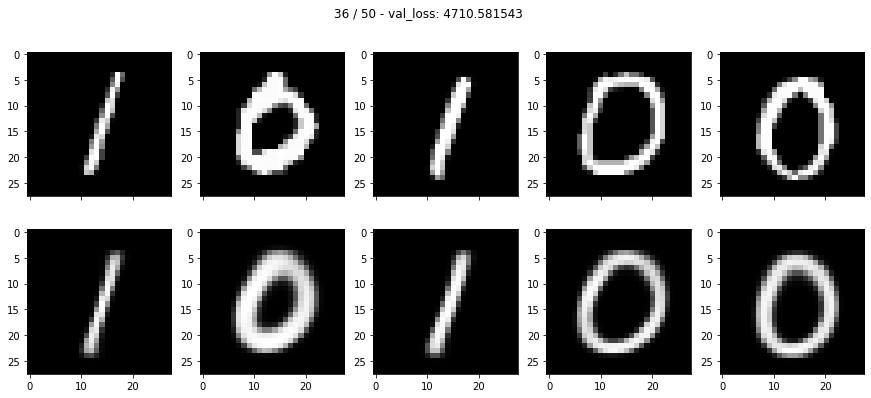

* Epoch 37/50
train loss: 5845.180176


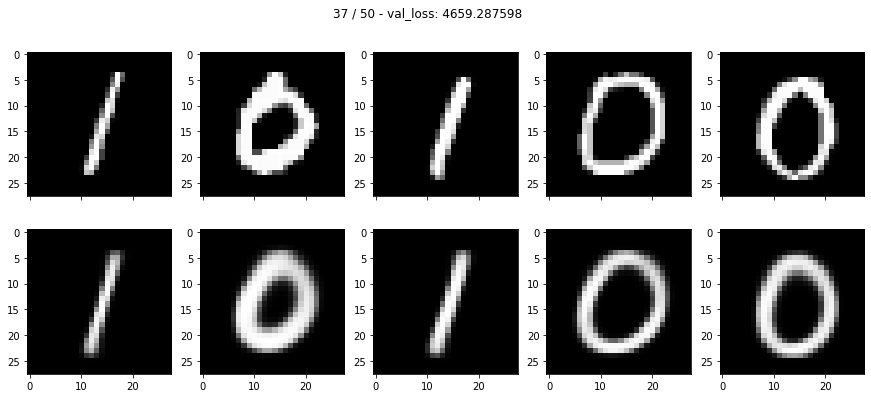

* Epoch 38/50
train loss: 5829.555664


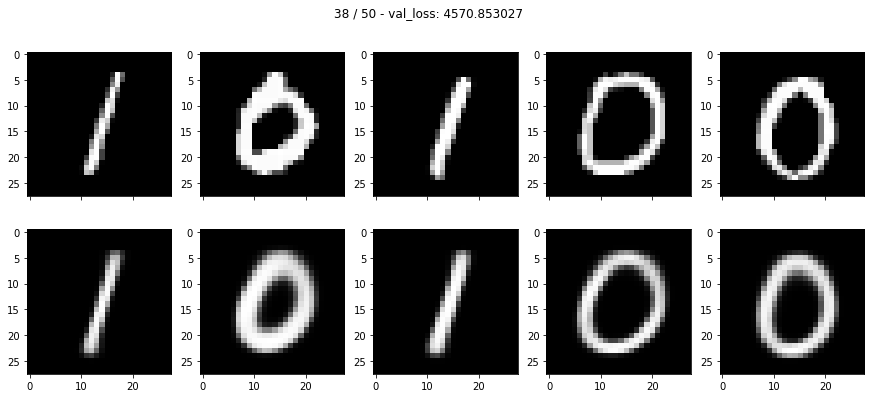

* Epoch 39/50
train loss: 5769.776855


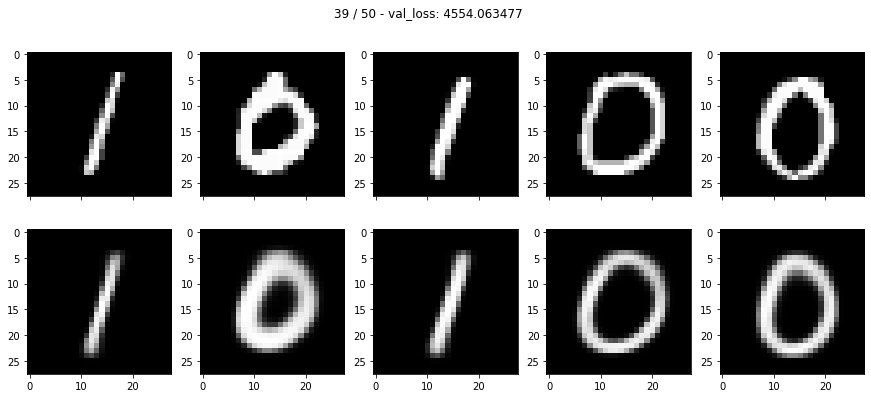

* Epoch 40/50
train loss: 5738.437500


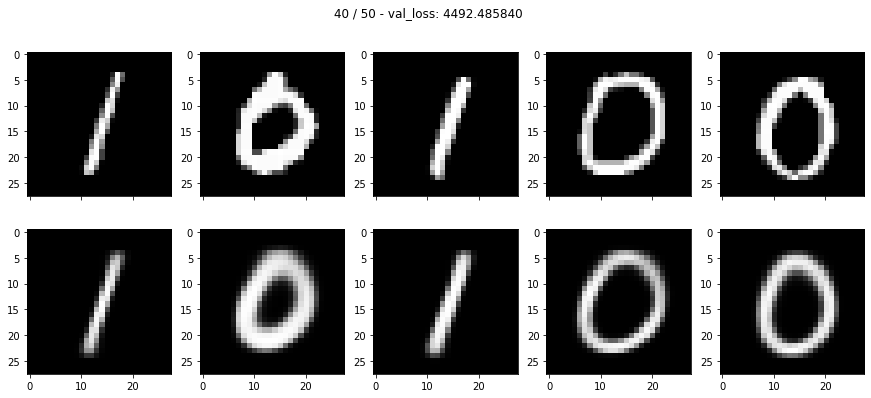

* Epoch 41/50
train loss: 5685.686523


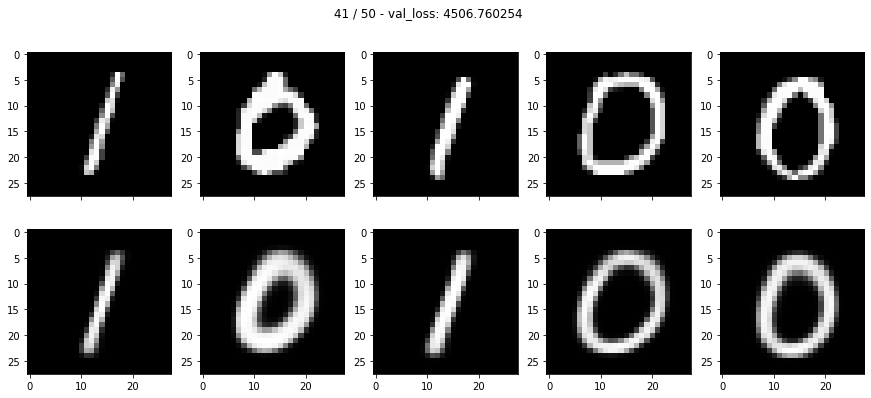

* Epoch 42/50
train loss: 5654.837891


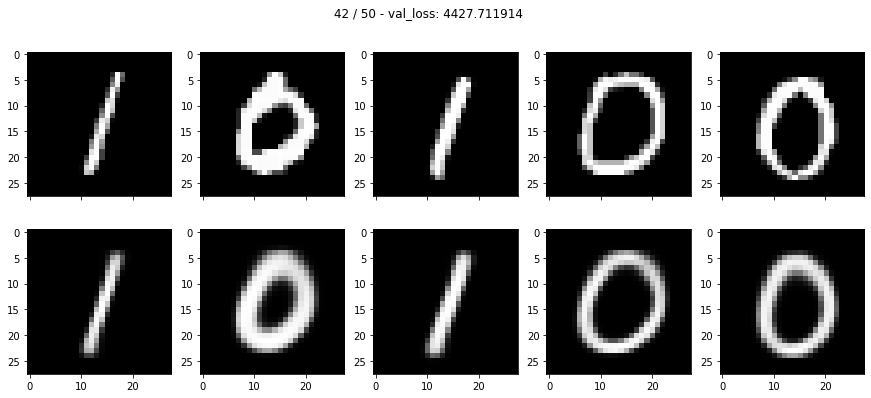

* Epoch 43/50
train loss: 5624.715820


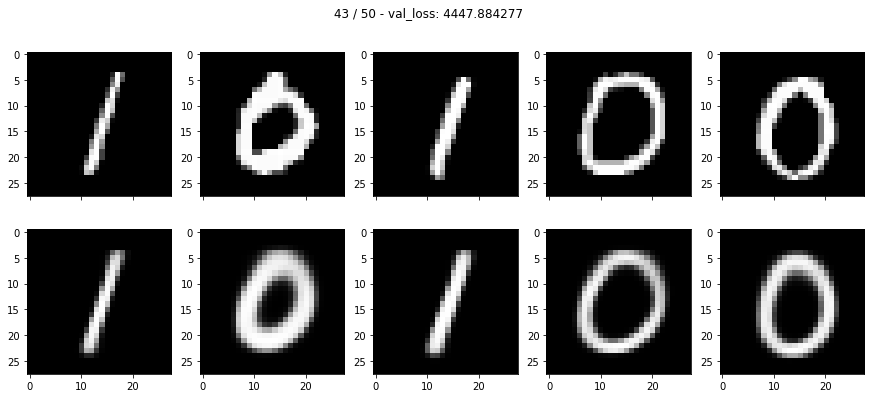

* Epoch 44/50
train loss: 5646.841797


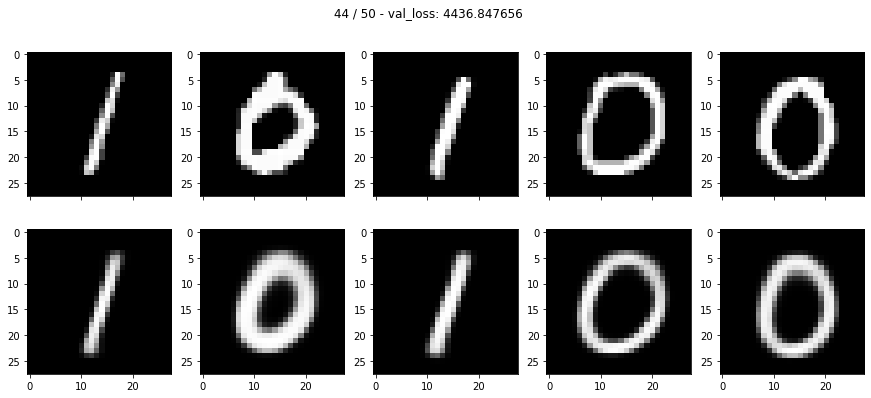

* Epoch 45/50
train loss: 5609.046875


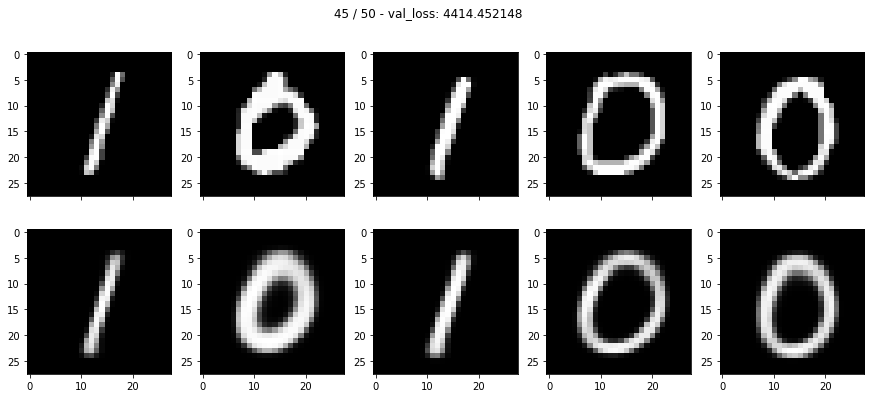

* Epoch 46/50
train loss: 5554.373047


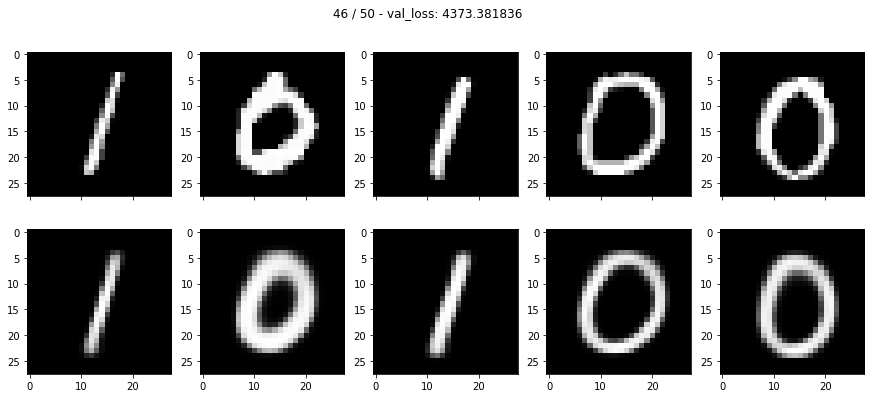

* Epoch 47/50
train loss: 5539.662109


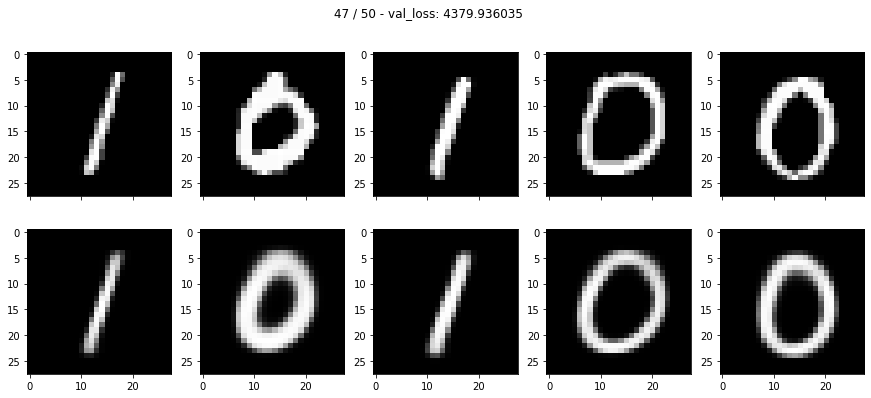

* Epoch 48/50
train loss: 5516.626465


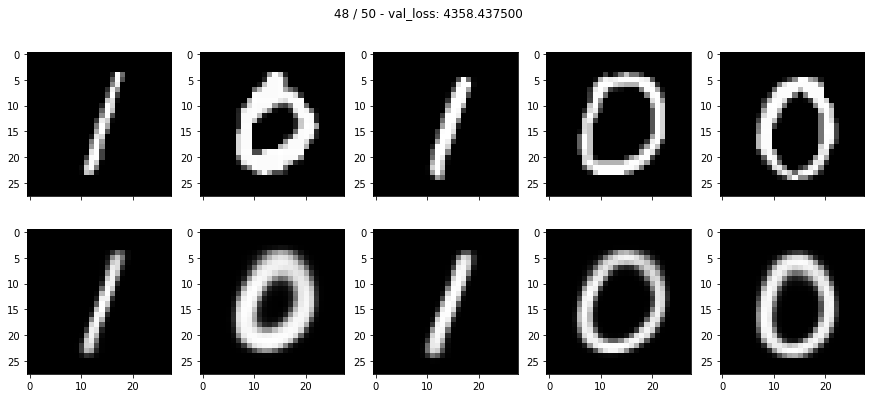

* Epoch 49/50
train loss: 5522.288574


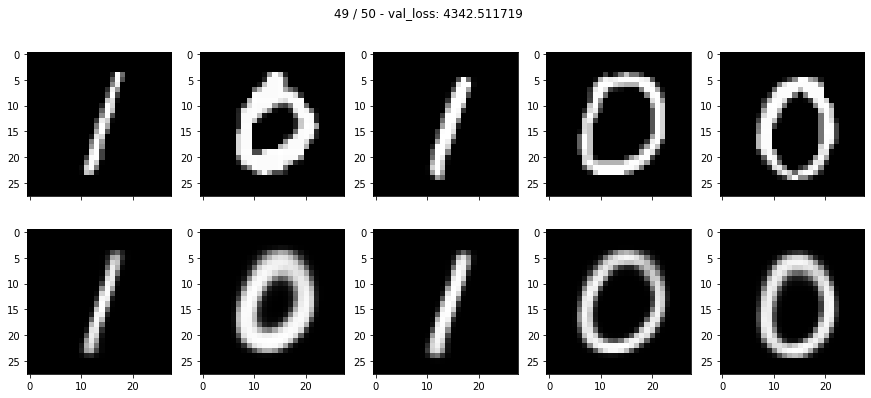

* Epoch 50/50
train loss: 5478.677246


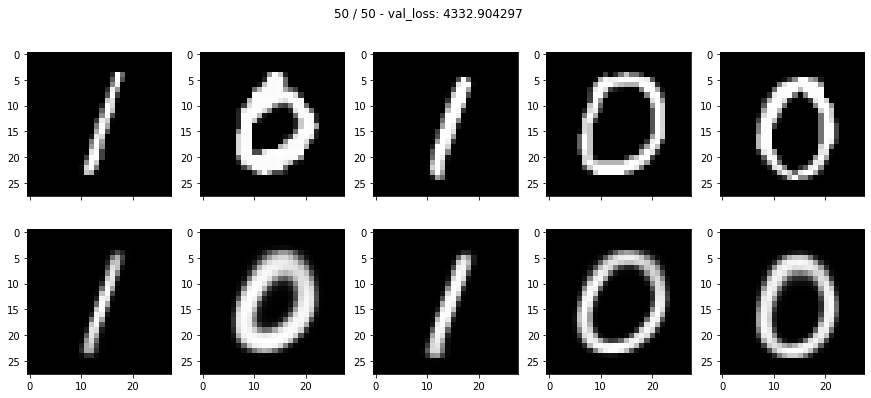

CPU times: user 2min 36s, sys: 2.47 s, total: 2min 38s
Wall time: 2min 38s


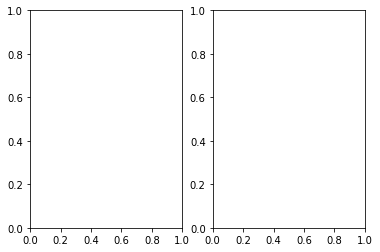

In [ ]:
%%time
vae_train(autoencoder, optimizer, scheduler, 50, criterion, train_loader, test_loader)

torch.Size([5, 1, 28, 28])


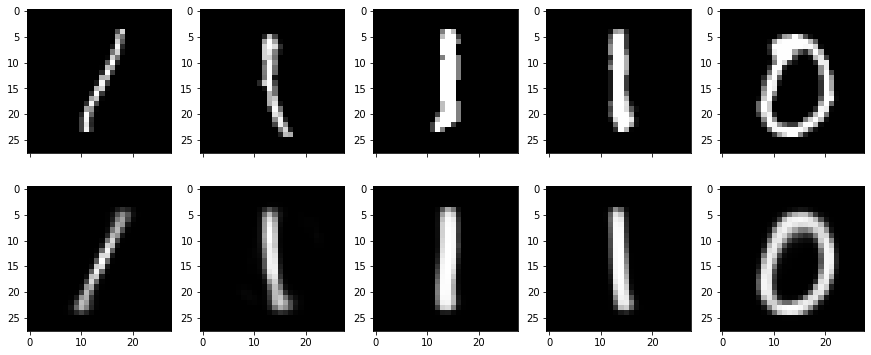

In [ ]:
x_val = next(iter(test_loader))
x_val = x_val[random.sample(range(0,len(x_val)), 5)]
print(x_val.shape)

autoencoder.eval()
with torch.set_grad_enabled(False):
    val_mu, val_logsigma, val_reconstruction = autoencoder(x_val[:5].to(device))

fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(x_val[j].cpu().squeeze(), cmap ='gray')

for j in range(5):
    ax[1][j].imshow(val_reconstruction[j].cpu().squeeze(), cmap = 'gray')
plt.show() 

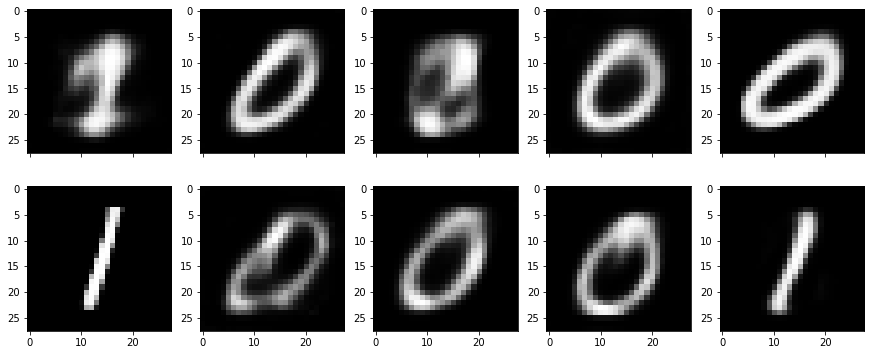

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
sum of 0 in generated samples: tensor(5622, device='cuda:0')
sum of 1 in generated samples: tensor(7026, device='cuda:0')
sum of 2 in generated samples: tensor(3, device='cuda:0')
sum of 3 in generated samples: tensor(0, device='cuda:0')
sum of 4 in generated samples: tensor(0, device='cuda:0')
sum of 5 in generated samples: tensor(1, device='cuda:0')
sum of 6 in generated samples: tensor(2, device='cuda:0')
sum of 7 in generated samples: tensor(1, device='cuda:0')
sum of 8 in generated samples: tensor(6, device='cuda:0')
sum of 9 in generated samples: tensor(4, device='cuda:0')


In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(len(X_train_01))])
autoencoder.eval()
with torch.set_grad_enabled(False):
    output = autoencoder.decode(torch.Tensor(z).to(device))

fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(output[j].squeeze().cpu(), cmap ='gray')

for j in range(5):
    ax[1][j].imshow(output[j+5].cpu().squeeze(), cmap = 'gray')
plt.show()

prev_X = output
prev_y = lenet(output).argmax(dim=1)
print(prev_y[:10])
for i in range(max(prev_y)+1):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

In [ ]:
new_X_train = torch.cat((prev_X, X_train_23.to(device)))
new_y_train = torch.cat((prev_y, y_train_23.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = X_test_01.to(device)
prev_y_test = y_test_01.to(device)
cur_X_test = torch.cat((prev_X_test, X_test_23.to(device)))
cur_y_test = torch.cat((prev_y_test, y_test_23.to(device)))
my_ewc = EWC(prev_X, prev_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
%%time
ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=2, ewc=my_ewc, importance=5e5, epochs=10) #обучаем классификатор на 0123  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy on current task:  tensor(0.9670)
accuracy on old task:  tensor(0.9343)
accuracy on 01:  tensor(0.9329)
accuracy on 23:  tensor(0.9559)
accuracy on current task:  tensor(0.9702)
accuracy on old task:  tensor(0.8979)
accuracy on 01:  tensor(0.8917)
accuracy on 23:  tensor(0.9687)
accuracy on current task:  tensor(0.9685)
accuracy on old task:  tensor(0.8846)
accuracy on 01:  tensor(0.8790)
accuracy on 23:  tensor(0.9706)
accuracy on current task:  tensor(0.9747)
accuracy on old task:  tensor(0.8898)
accuracy on 01:  tensor(0.8870)
accuracy on 23:  tensor(0.9760)
accuracy on current task:  tensor(0.9711)
accuracy on old task:  tensor(0.8733)
accuracy on 01:  tensor(0.8775)
accuracy on 23:  tensor(0.9765)
accuracy on current task:  tensor(0.9699)
accuracy on old task:  tensor(0.8634)
accuracy on 01:  tensor(0.8582)
accuracy on 23:  tensor(0.9765)
accuracy on current task:  tensor(0.9791)
accuracy on old task:  tensor(0.8894)
accuracy on 01:  tensor(0.8936)
accuracy on 23:  tensor(

x_val shape = torch.Size([64, 1, 28, 28])
* Epoch 1/50
train loss: 9641.001953


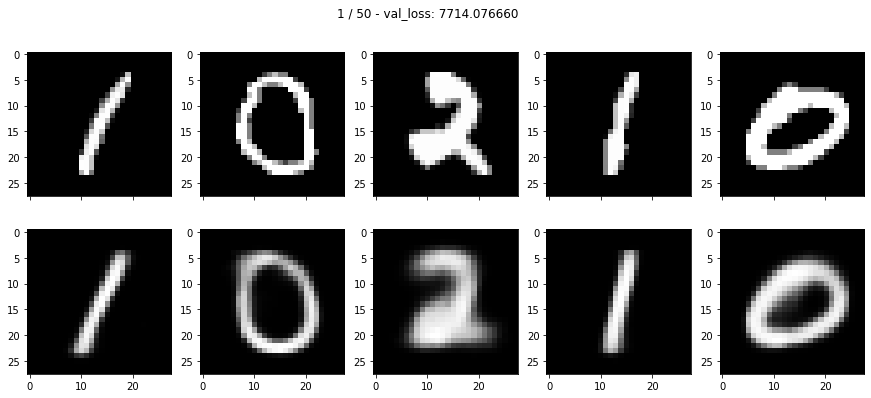

* Epoch 2/50
train loss: 9248.438477


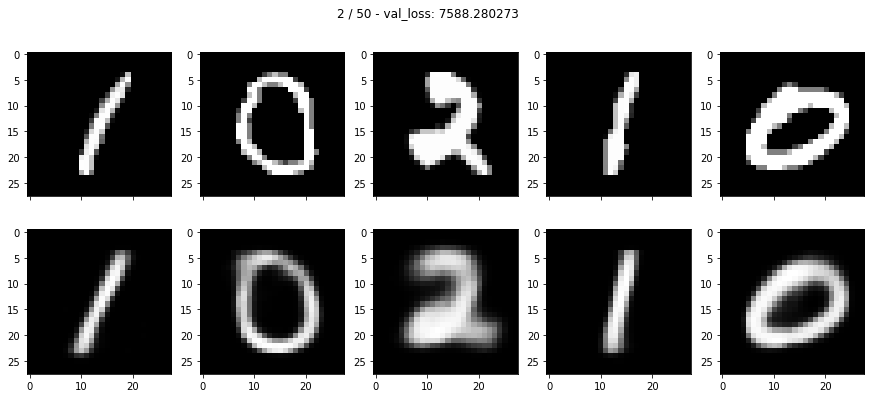

* Epoch 3/50
train loss: 9109.241211


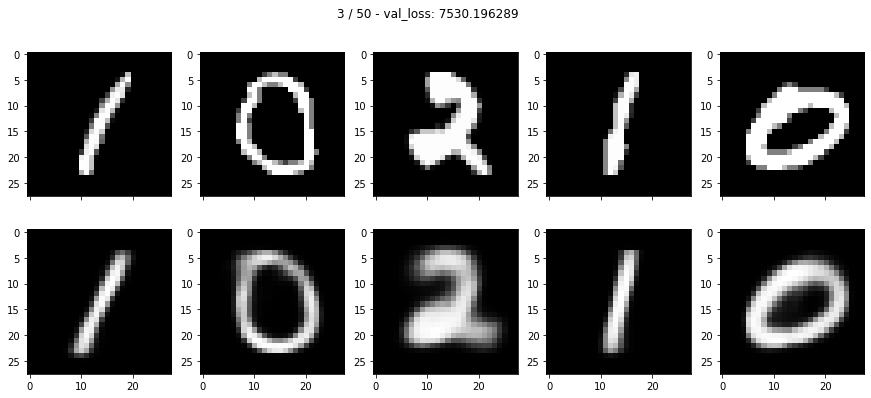

* Epoch 4/50
train loss: 8995.352539


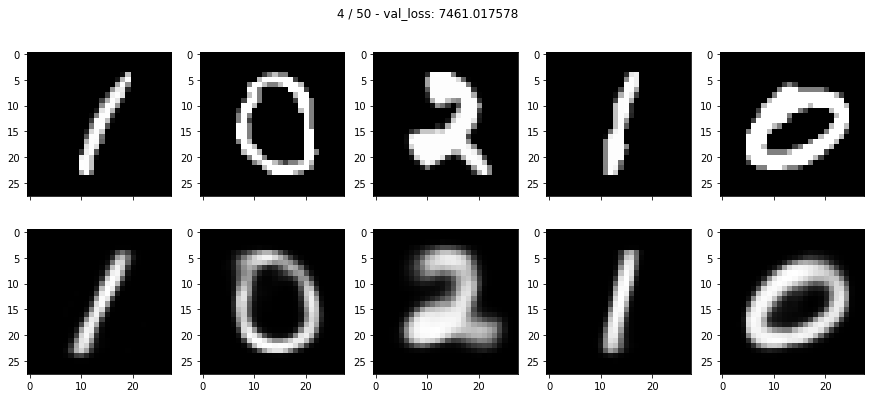

* Epoch 5/50
train loss: 8916.640625


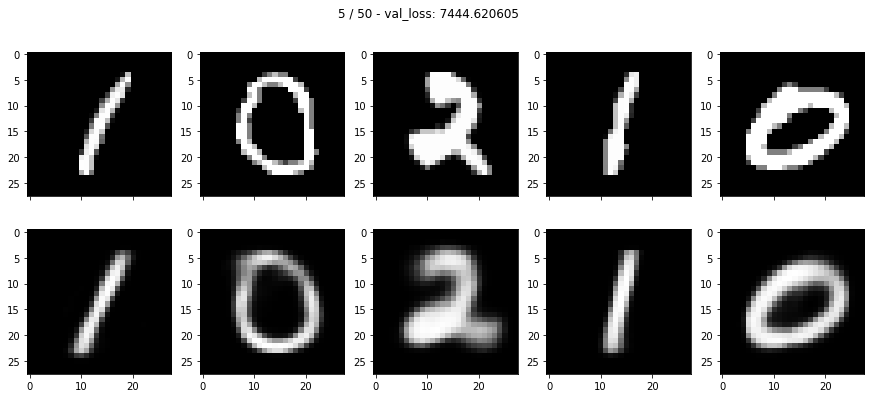

* Epoch 6/50
train loss: 8871.071289


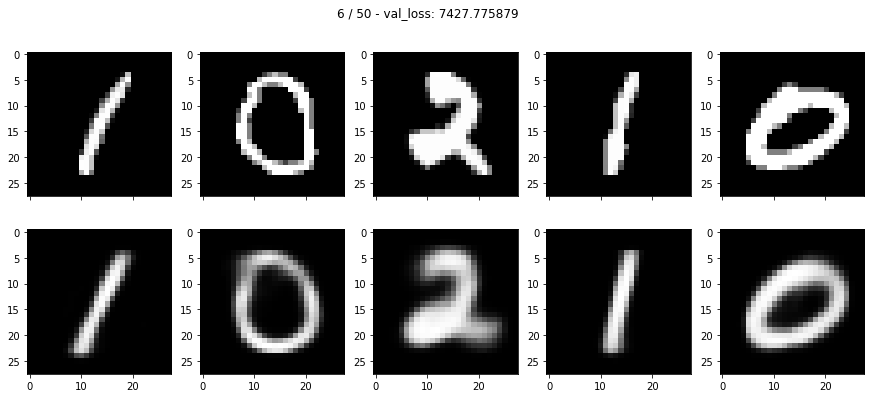

* Epoch 7/50
train loss: 8812.001953


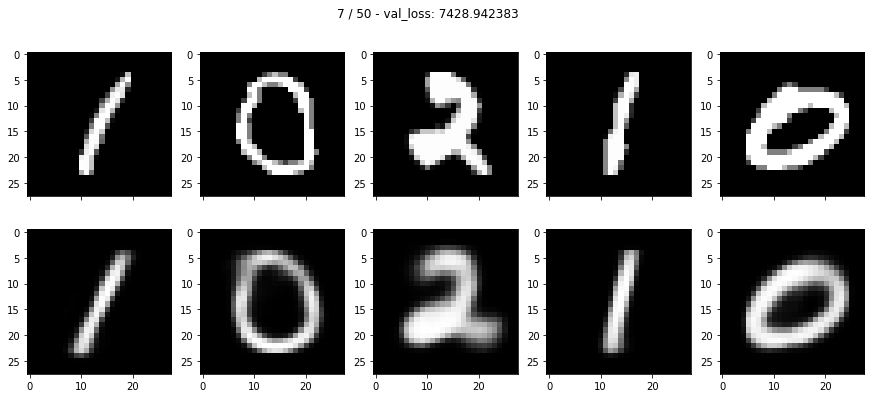

* Epoch 8/50
train loss: 8772.304688


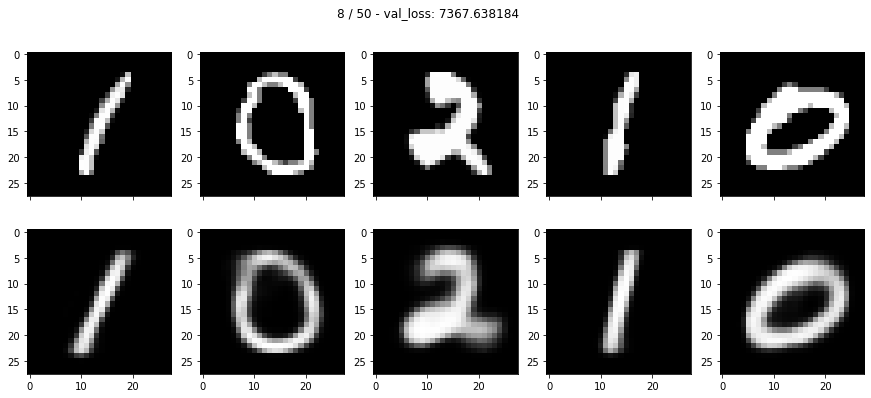

* Epoch 9/50
train loss: 8723.854492


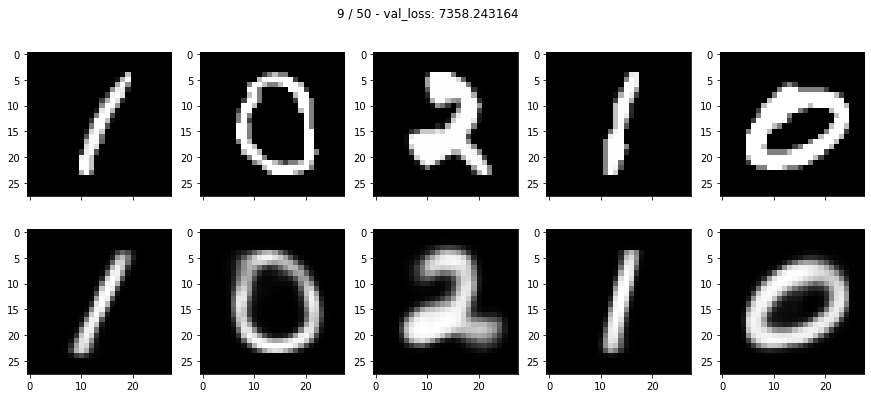

* Epoch 10/50
train loss: 8680.320312


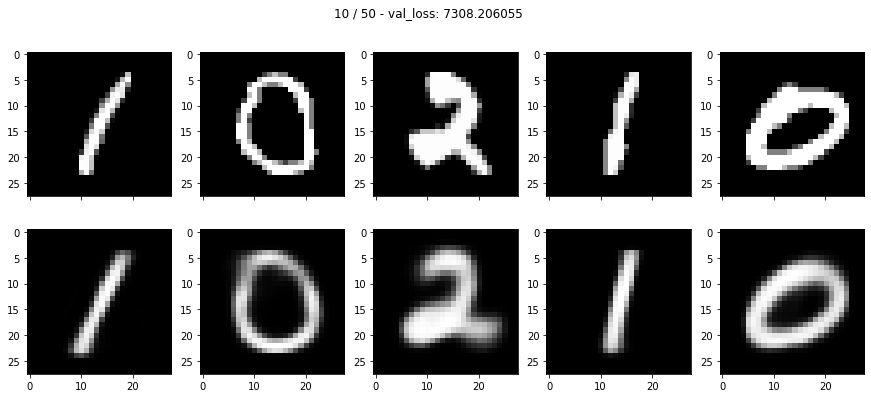

* Epoch 11/50
train loss: 8669.987305


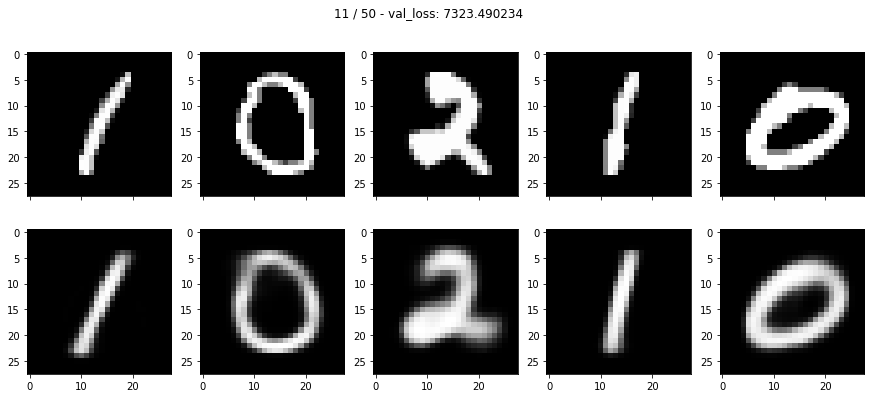

* Epoch 12/50
train loss: 8652.201172


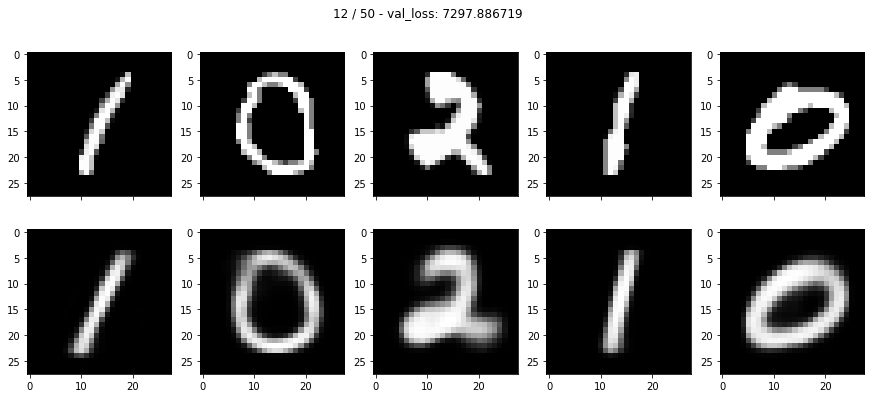

* Epoch 13/50
train loss: 8606.193359


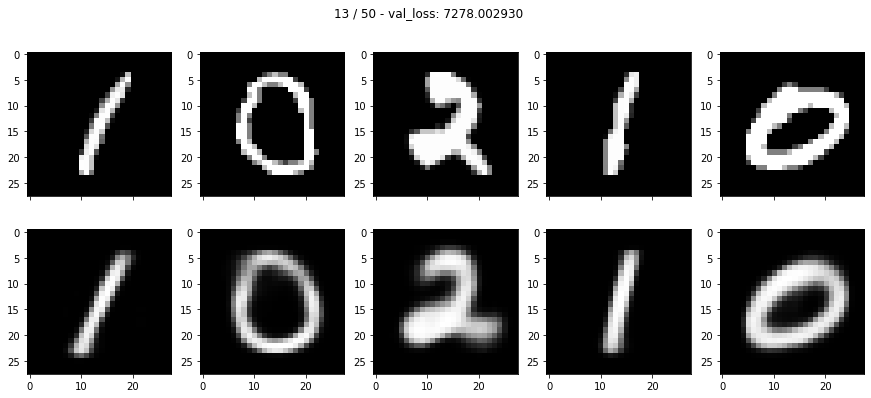

* Epoch 14/50
train loss: 8586.859375


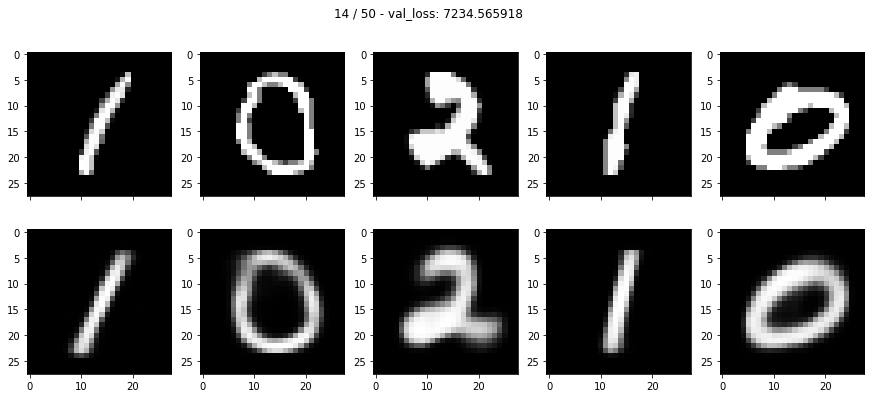

* Epoch 15/50
train loss: 8547.544922


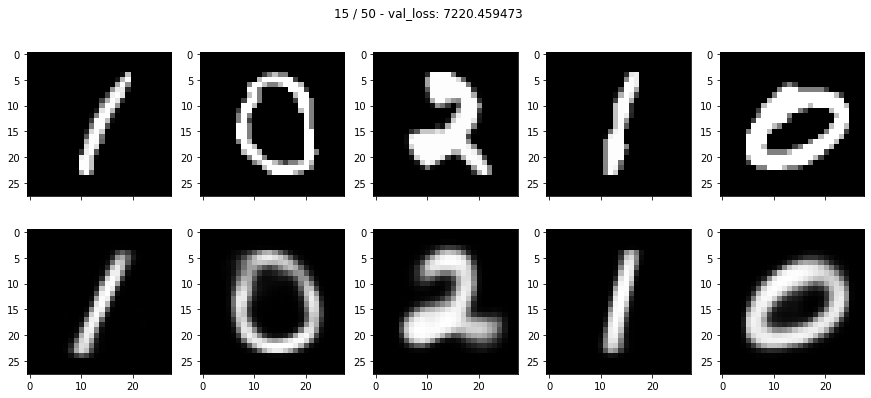

* Epoch 16/50
train loss: 8531.317383


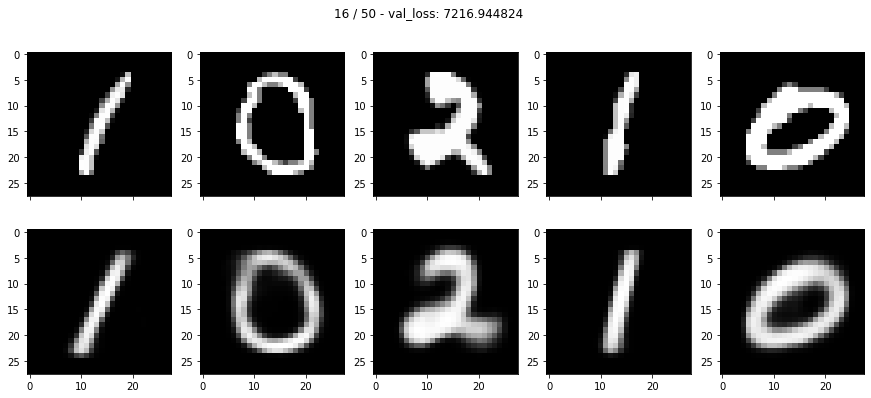

* Epoch 17/50
train loss: 8519.026367


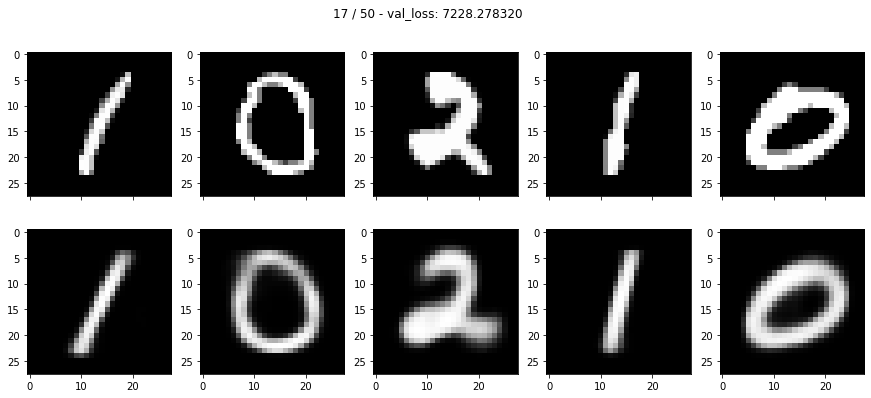

* Epoch 18/50
train loss: 8506.912109


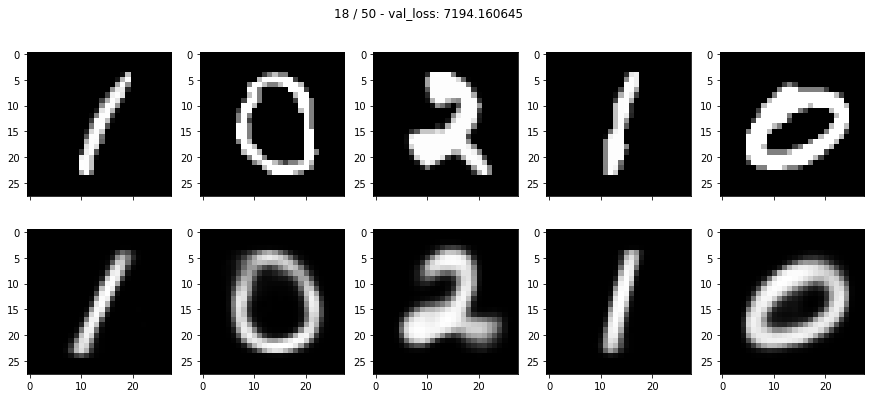

* Epoch 19/50
train loss: 8483.239258


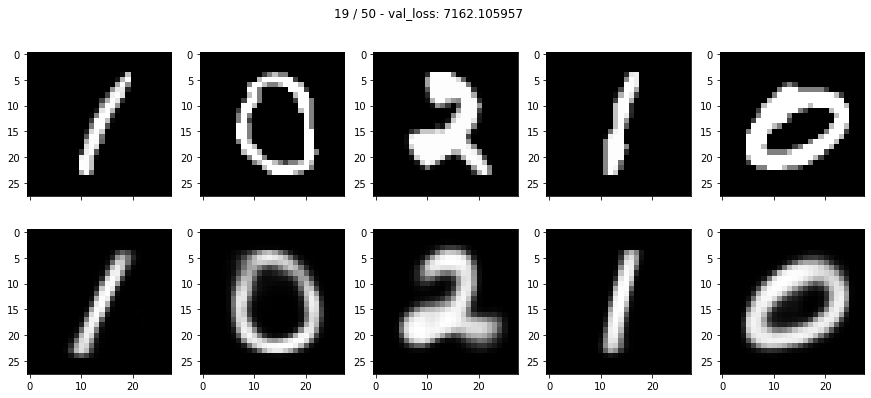

* Epoch 20/50
train loss: 8479.865234


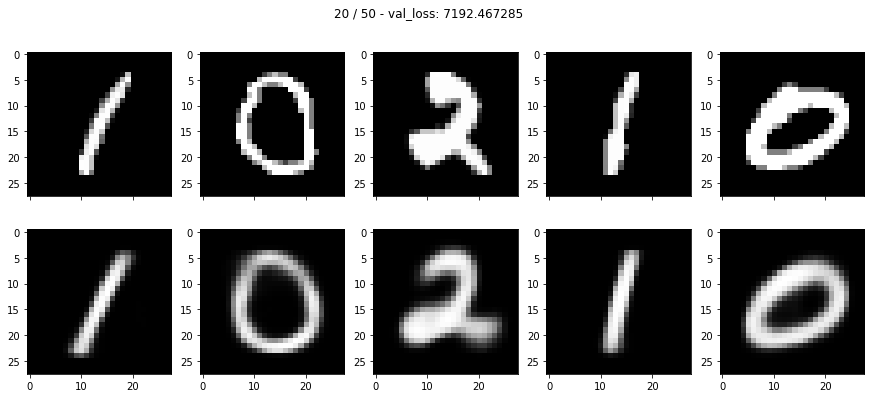

* Epoch 21/50
train loss: 8458.803711


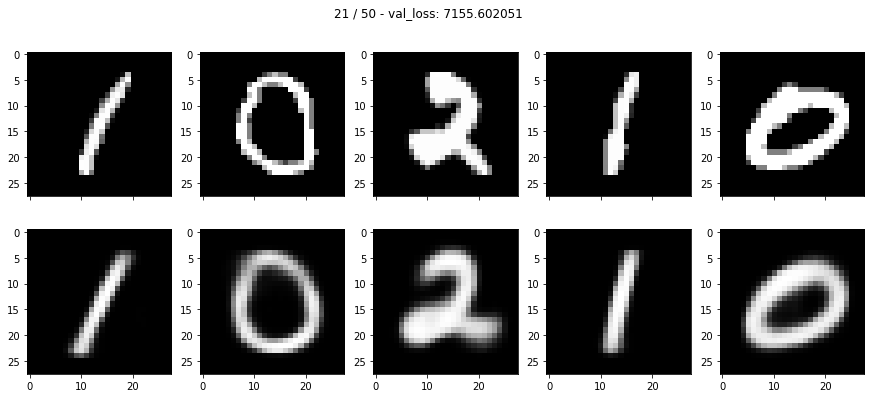

* Epoch 22/50
train loss: 8434.223633


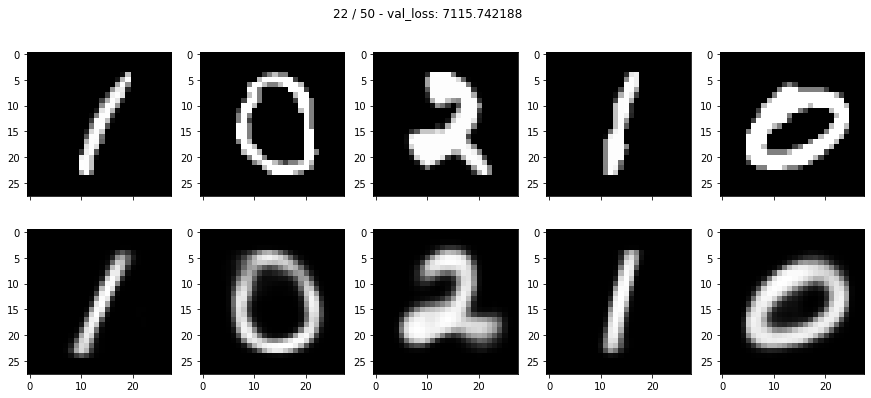

* Epoch 23/50
train loss: 8438.681641


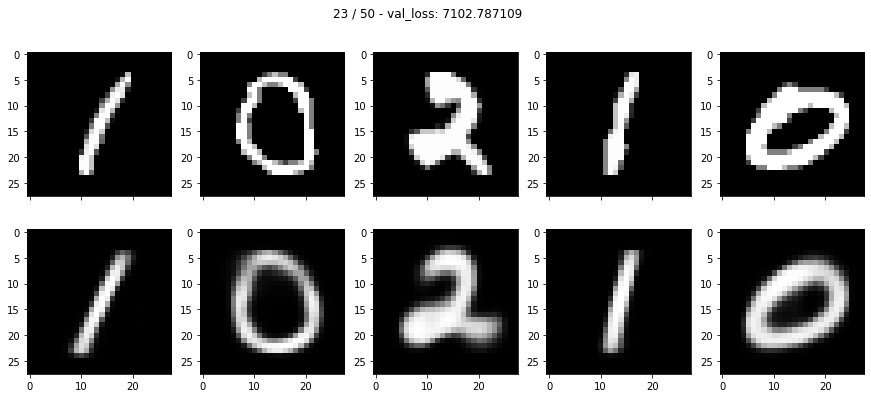

* Epoch 24/50
train loss: 8401.621094


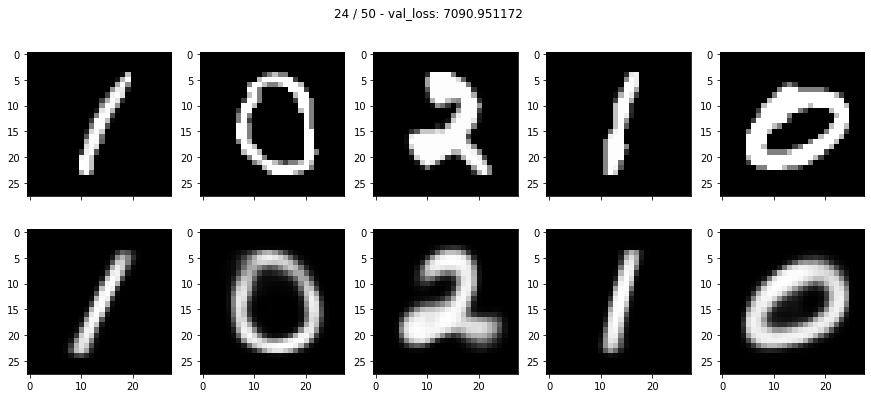

* Epoch 25/50
train loss: 8398.700195


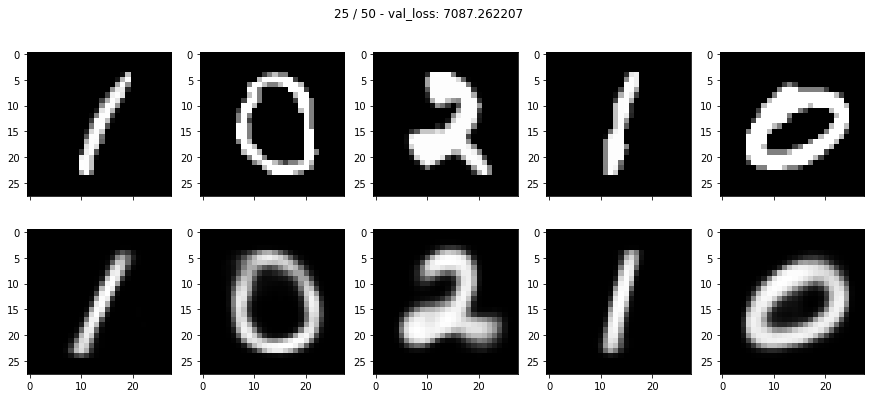

* Epoch 26/50
train loss: 8389.108398


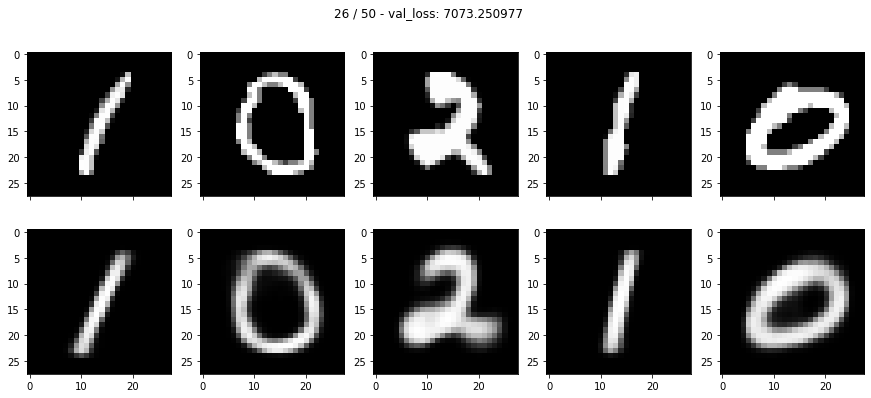

* Epoch 27/50
train loss: 8374.037109


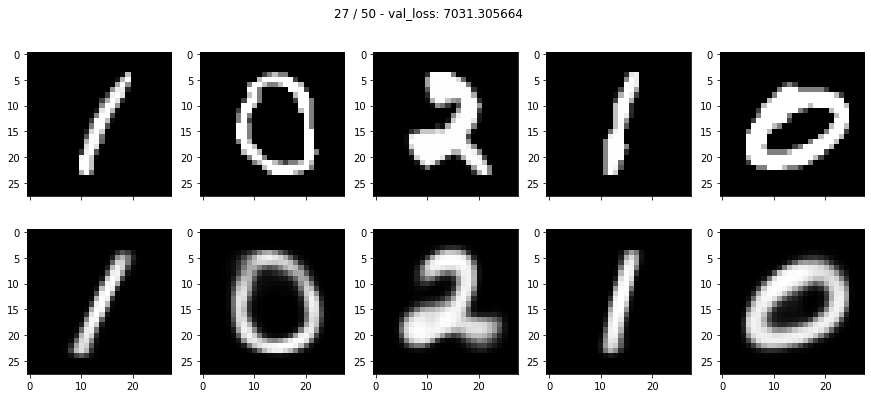

* Epoch 28/50
train loss: 8370.384766


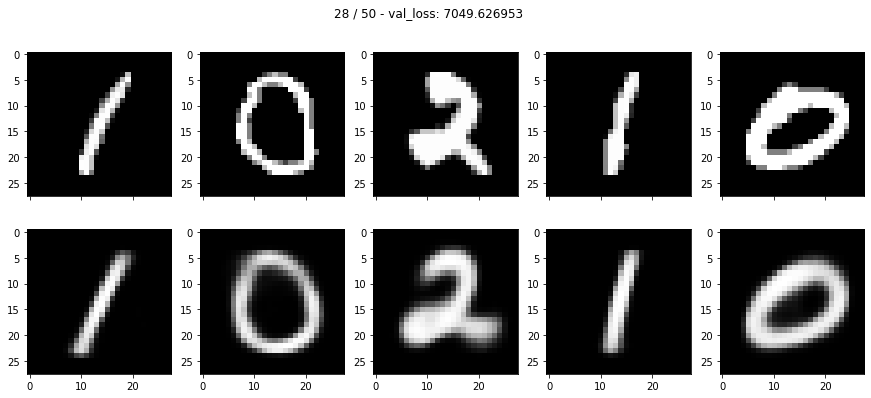

* Epoch 29/50
train loss: 8354.934570


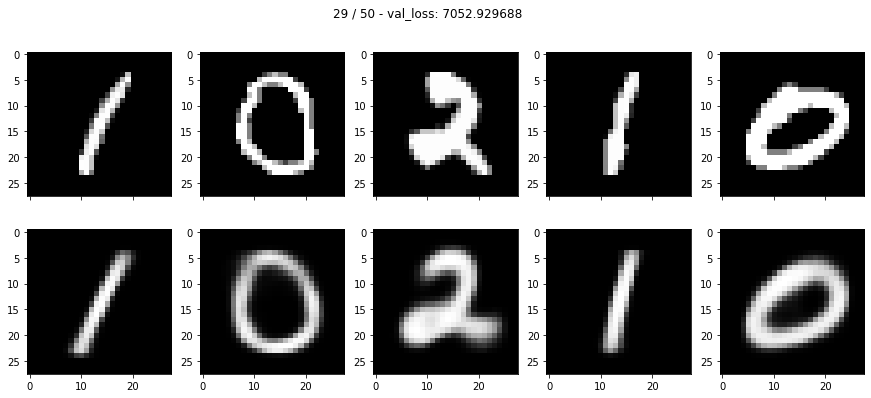

* Epoch 30/50
train loss: 8360.067383


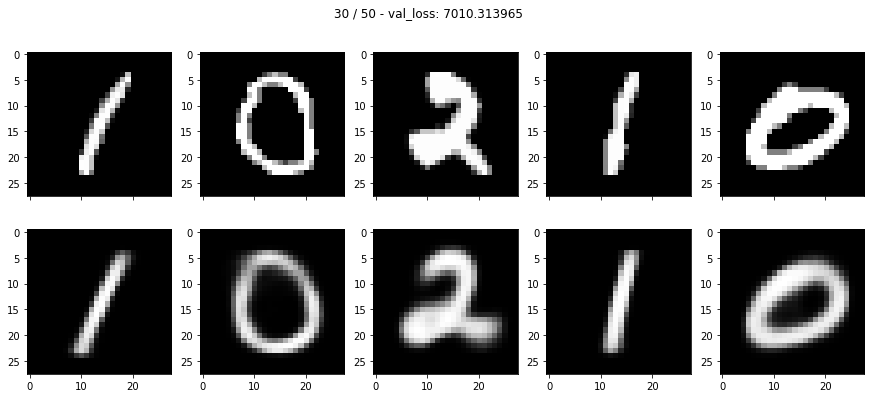

* Epoch 31/50
train loss: 8329.295898


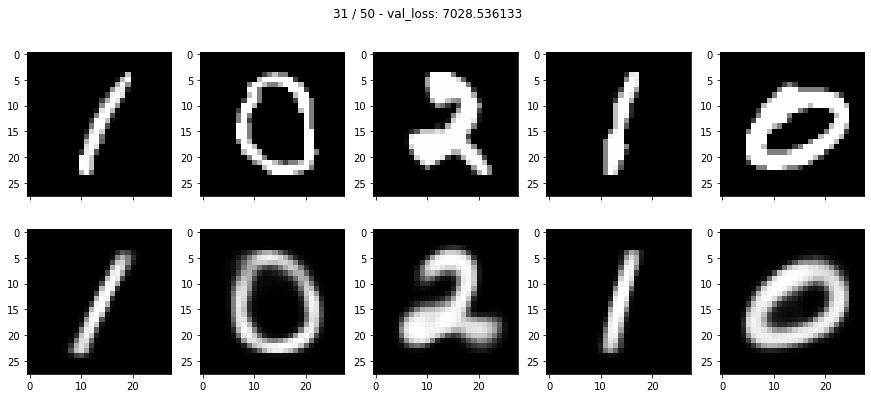

* Epoch 32/50
train loss: 8324.089844


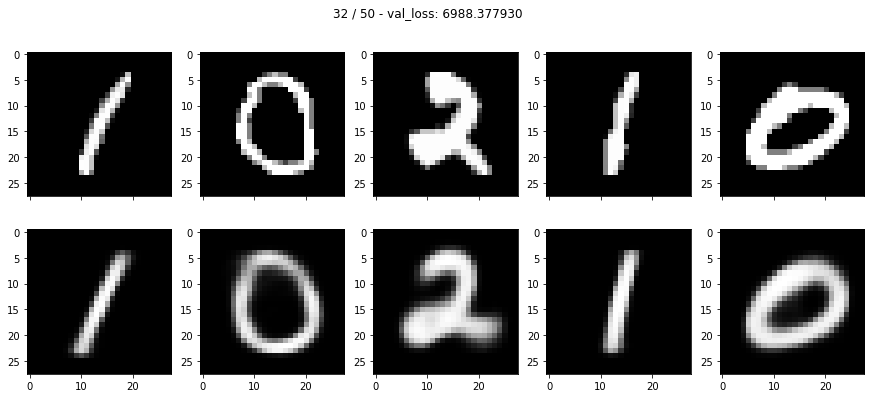

* Epoch 33/50
train loss: 8304.610352


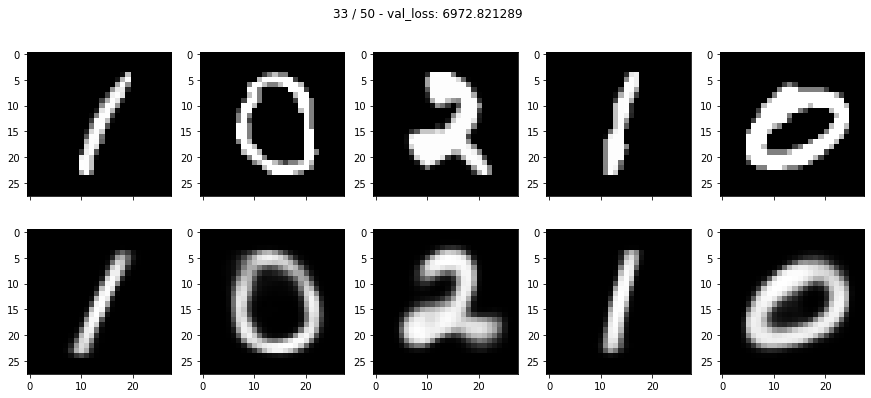

* Epoch 34/50
train loss: 8305.610352


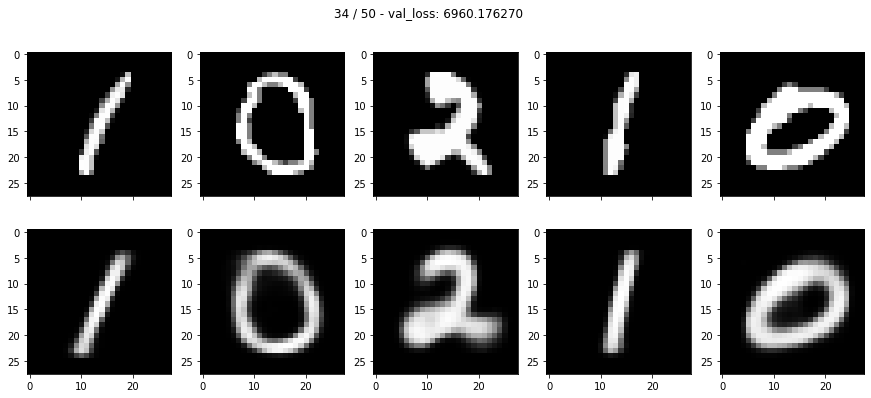

* Epoch 35/50
train loss: 8289.439453


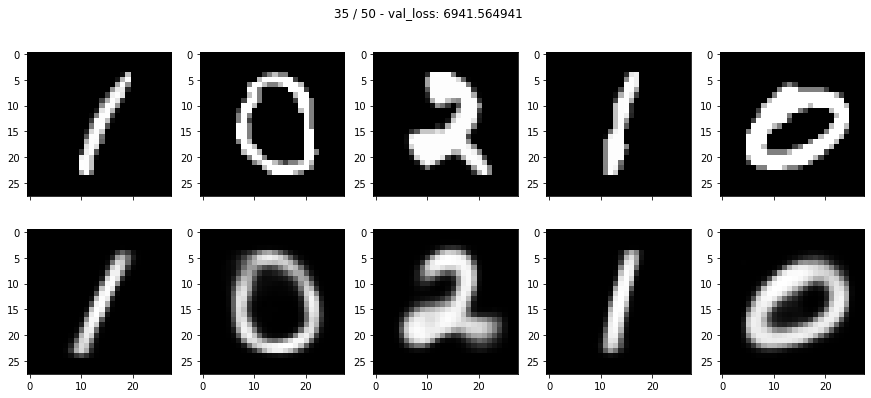

* Epoch 36/50
train loss: 8281.843750


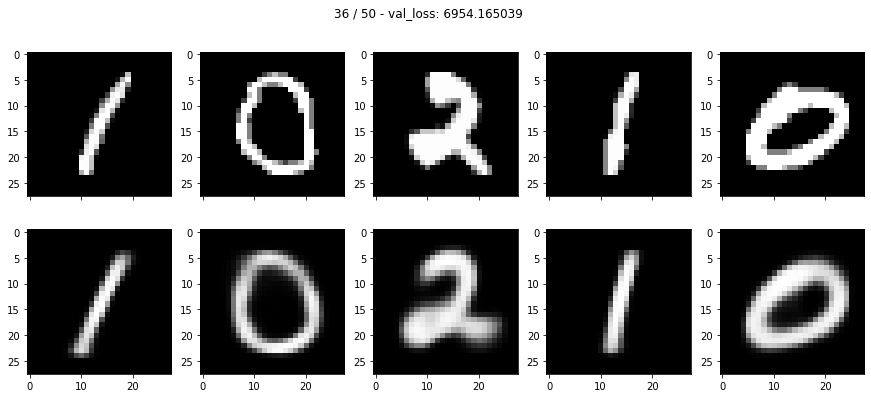

* Epoch 37/50
train loss: 8264.955078


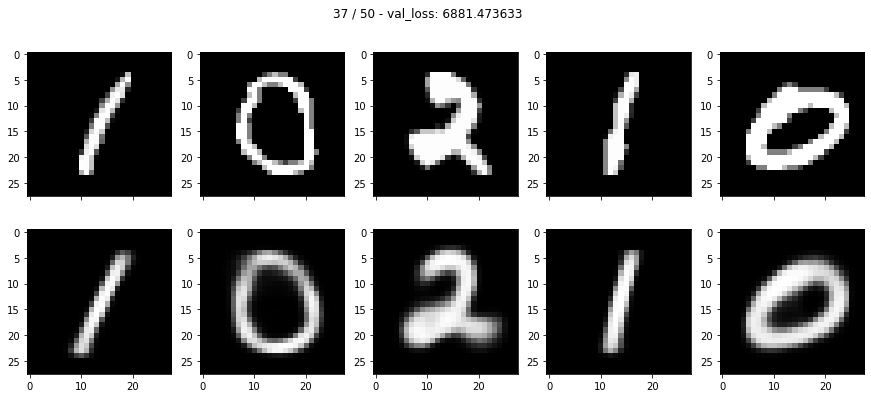

* Epoch 38/50
train loss: 8268.268555


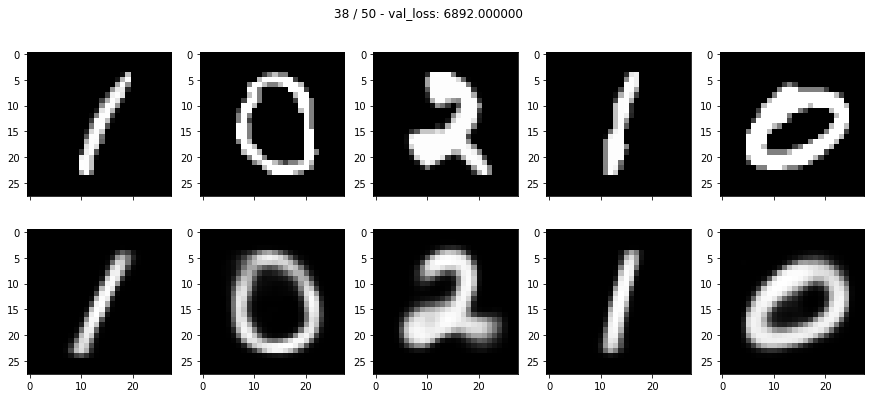

* Epoch 39/50
train loss: 8240.161133


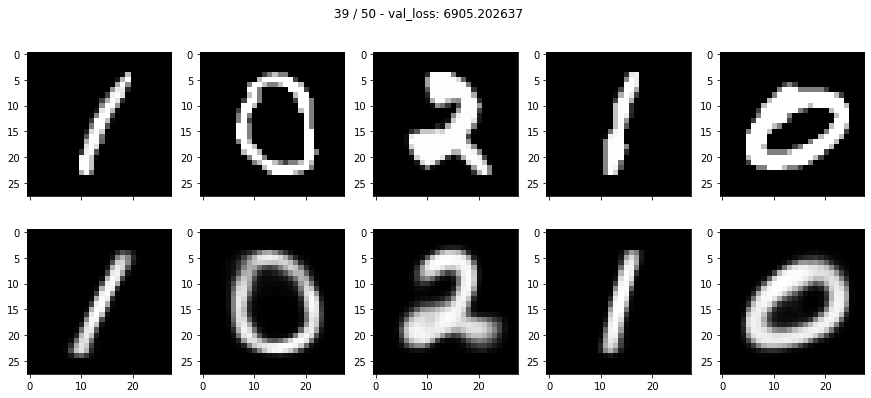

* Epoch 40/50
train loss: 8229.739258


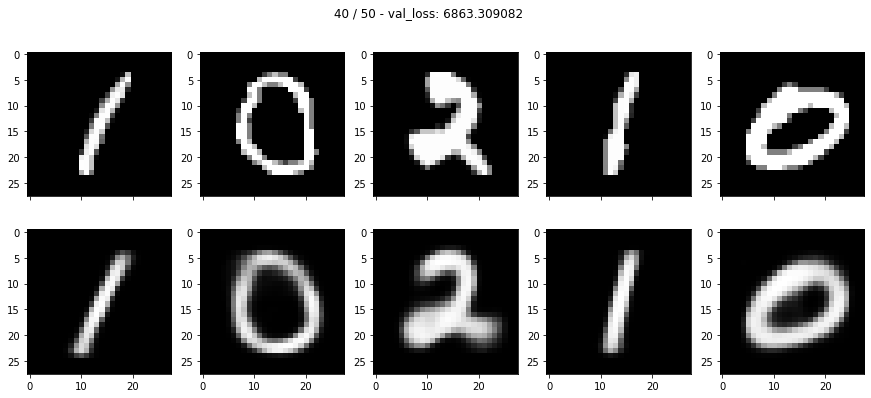

* Epoch 41/50
train loss: 8220.792969


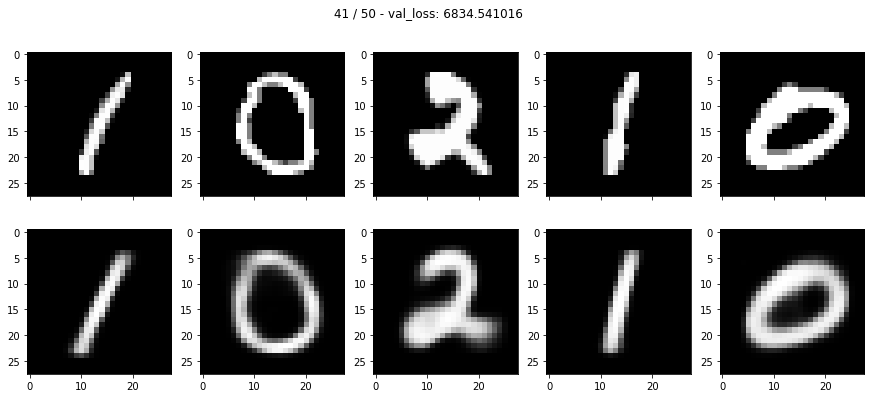

* Epoch 42/50
train loss: 8207.102539


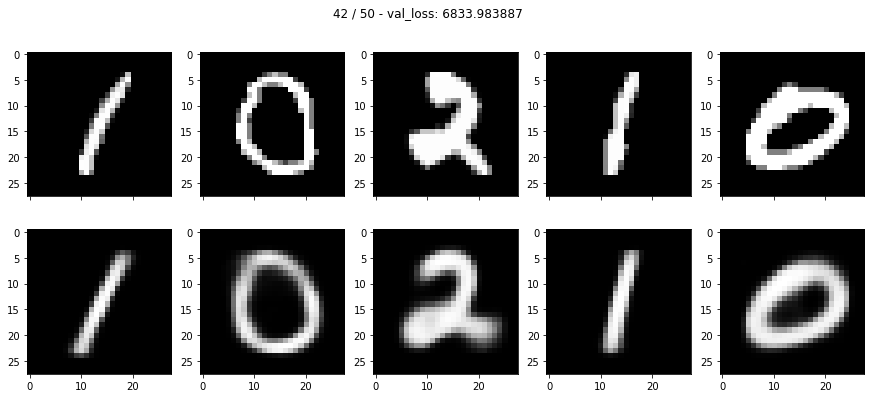

* Epoch 43/50
train loss: 8202.665039


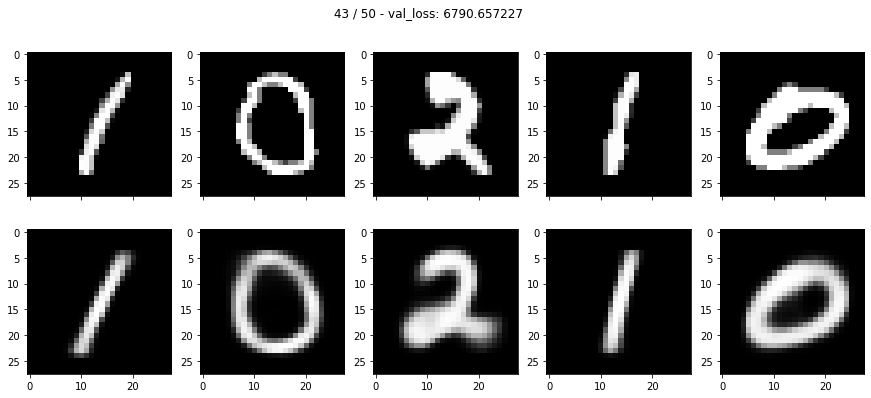

* Epoch 44/50
train loss: 8195.751953


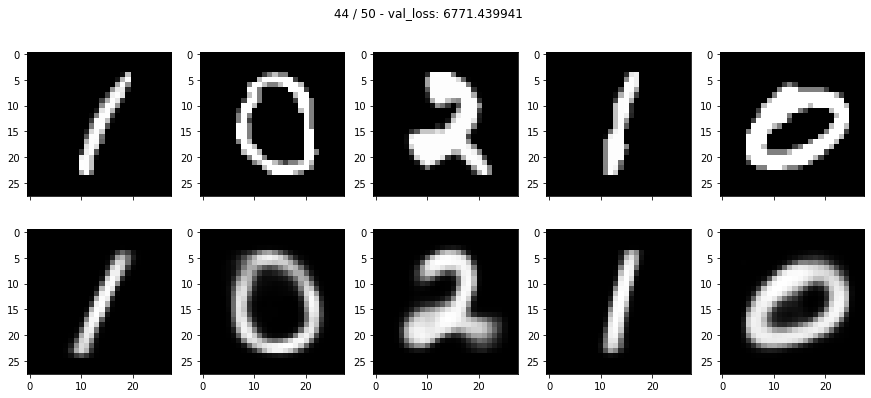

* Epoch 45/50
train loss: 8198.691406


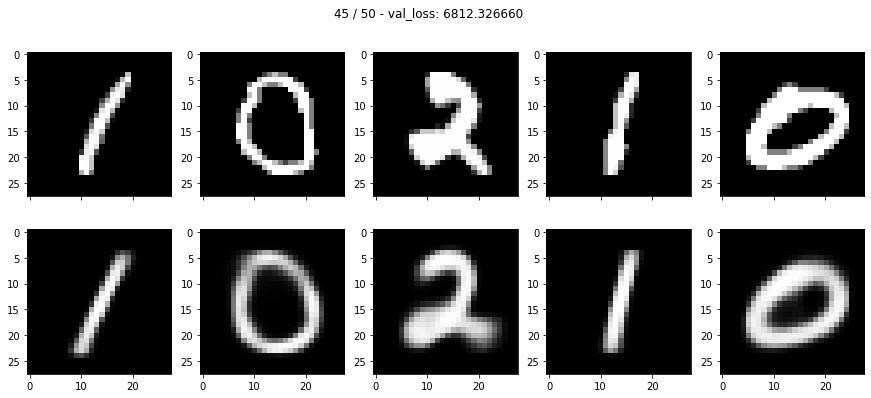

* Epoch 46/50
train loss: 8176.624512


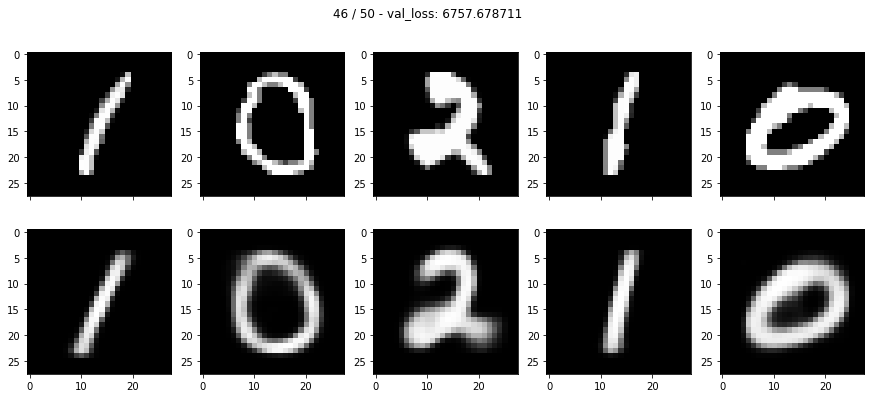

* Epoch 47/50
train loss: 8161.513184


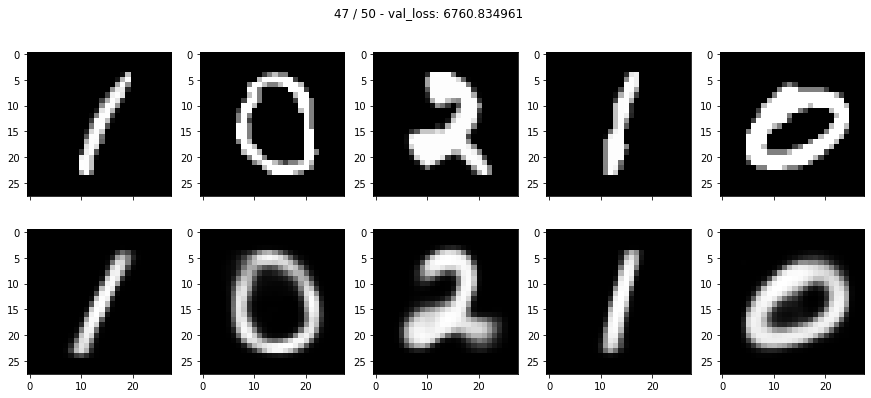

* Epoch 48/50
train loss: 8165.425293


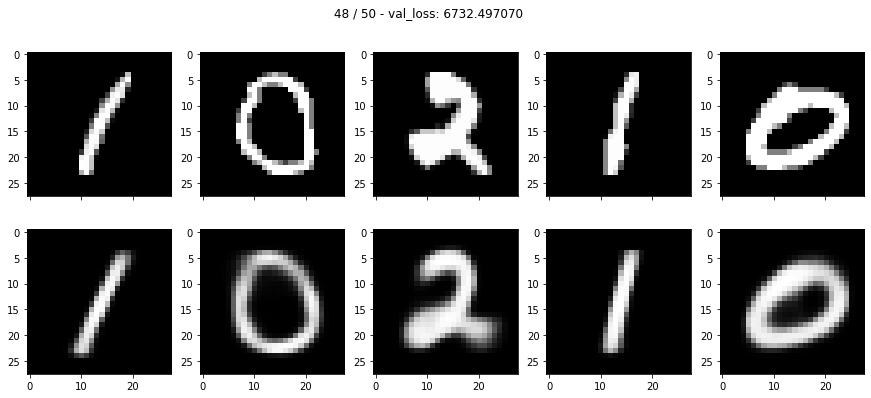

* Epoch 49/50
train loss: 8152.339844


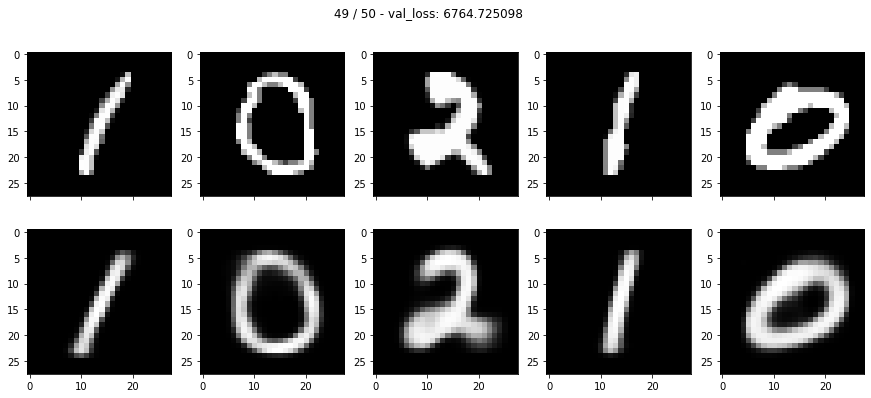

* Epoch 50/50
train loss: 8148.640137


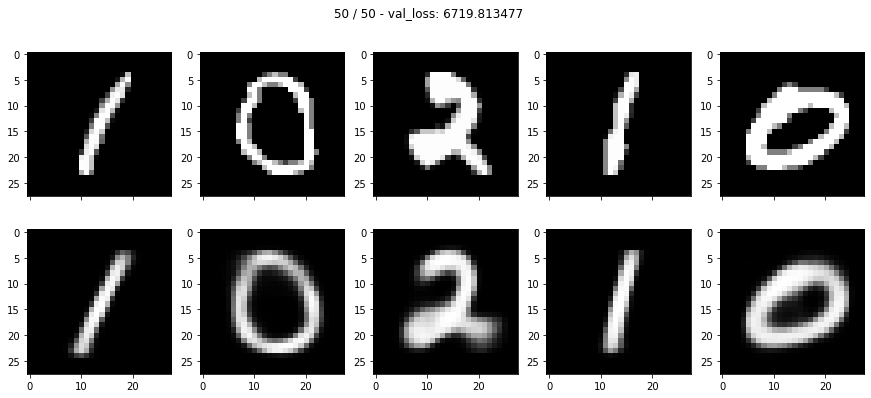

CPU times: user 3min 31s, sys: 3.65 s, total: 3min 35s
Wall time: 3min 34s


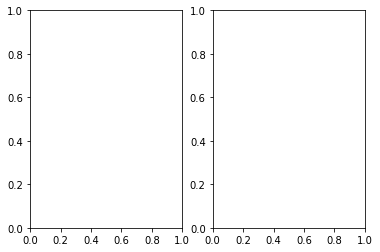

In [ ]:
%%time
train_loader = torch.utils.data.DataLoader(dataset=torch.cat((prev_X,X_train_23.to(device))), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.cat((X_test_01,X_test_23.to(device))), batch_size=batch_size, shuffle=True)
prev_len = len(torch.cat((prev_X,X_train_23.to(device))))
vae_train(autoencoder, optimizer, scheduler, 50, criterion, train_loader, test_loader)

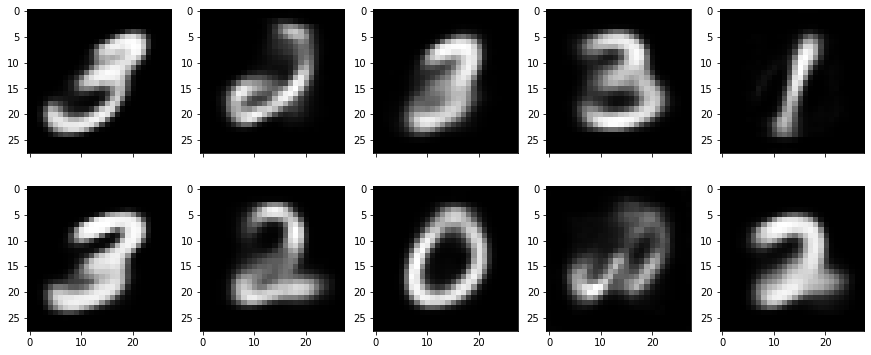

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([3, 2, 3, 3, 1, 3, 2, 0, 1, 2], device='cuda:0')
sum of 0 in generated samples: tensor(5769, device='cuda:0')
sum of 1 in generated samples: tensor(8455, device='cuda:0')
sum of 2 in generated samples: tensor(4620, device='cuda:0')
sum of 3 in generated samples: tensor(5910, device='cuda:0')


In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(prev_len)])
autoencoder.eval()
with torch.set_grad_enabled(False):
    output = autoencoder.decode(torch.Tensor(z).to(device))

fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(output[j].squeeze().cpu(), cmap ='gray')

for j in range(5):
    ax[1][j].imshow(output[j+5].cpu().squeeze(), cmap = 'gray')
plt.show()

prev_X = output
prev_y = lenet(output).argmax(dim=1)
print(prev_y[:10])

for i in range(max(prev_y+1)):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

In [ ]:
new_X_train = torch.cat((prev_X, X_train_45.to(device)))
new_y_train = torch.cat((prev_y, y_train_45.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_23.to(device)))
prev_y_test = torch.cat((prev_y_test, y_test_23.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_45.to(device)))
cur_y_test = torch.cat((prev_y_test, y_test_45.to(device)))
my_ewc = EWC(prev_X, prev_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
%%time
ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=3, ewc=my_ewc, importance=5e5, epochs=10) #обучаем классификатор на 012345

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy on current task:  tensor(0.8766)
accuracy on old task:  tensor(0.8470)
accuracy on 01:  tensor(0.7504)
accuracy on 23:  tensor(0.8247)
accuracy on 45:  tensor(0.8799)
accuracy on current task:  tensor(0.8821)
accuracy on old task:  tensor(0.8321)
accuracy on 01:  tensor(0.7173)
accuracy on 23:  tensor(0.8516)
accuracy on 45:  tensor(0.9365)
accuracy on current task:  tensor(0.9085)
accuracy on old task:  tensor(0.8749)
accuracy on 01:  tensor(0.7962)
accuracy on 23:  tensor(0.8810)
accuracy on 45:  tensor(0.9578)
accuracy on current task:  tensor(0.9105)
accuracy on old task:  tensor(0.8711)
accuracy on 01:  tensor(0.8175)
accuracy on 23:  tensor(0.8864)
accuracy on 45:  tensor(0.9493)
accuracy on current task:  tensor(0.8947)
accuracy on old task:  tensor(0.8374)
accuracy on 01:  tensor(0.7310)
accuracy on 23:  tensor(0.8648)
accuracy on 45:  tensor(0.9509)
accuracy on current task:  tensor(0.9075)
accuracy on old task:  tensor(0.8590)
accuracy on 01:  tensor(0.7645)
accuracy

x_val shape = torch.Size([64, 1, 28, 28])
* Epoch 1/50
train loss: 9670.213867


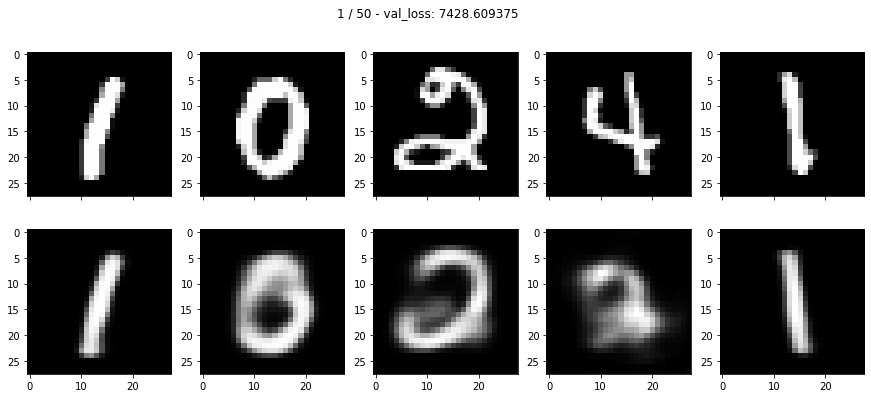

* Epoch 2/50
train loss: 9486.529297


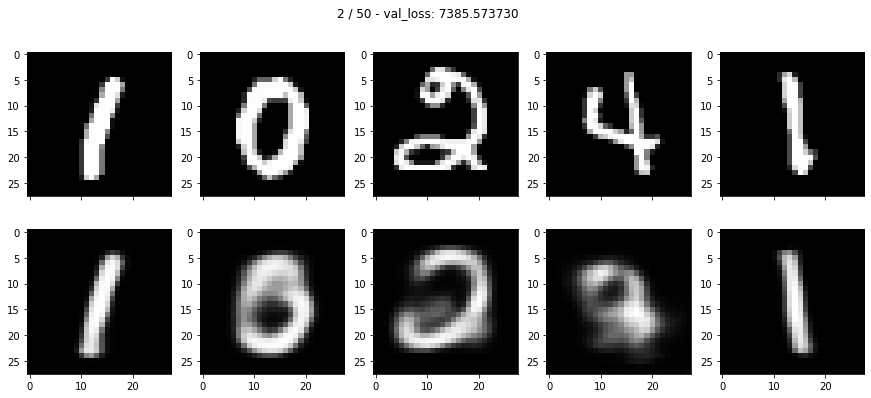

* Epoch 3/50
train loss: 9398.520508


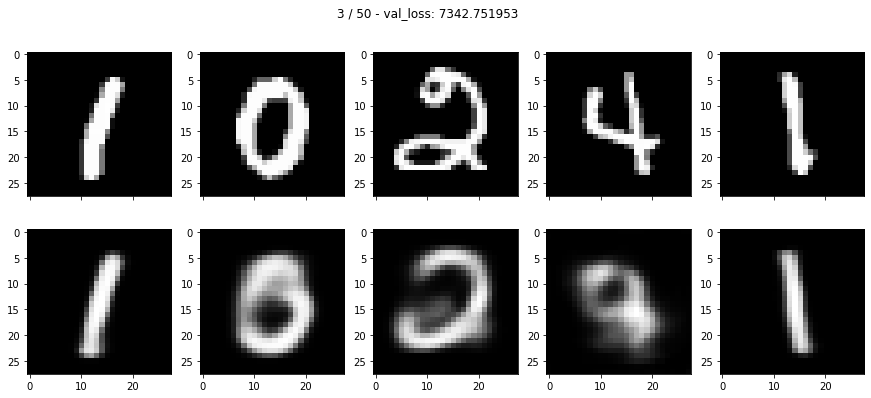

* Epoch 4/50
train loss: 9334.556641


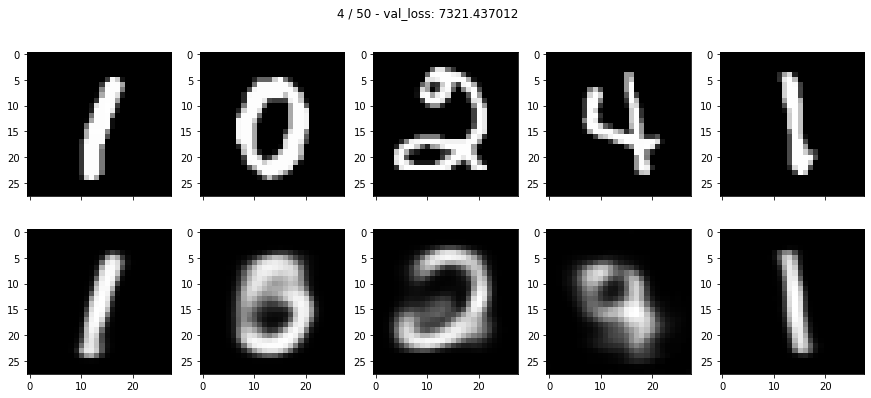

* Epoch 5/50
train loss: 9298.812500


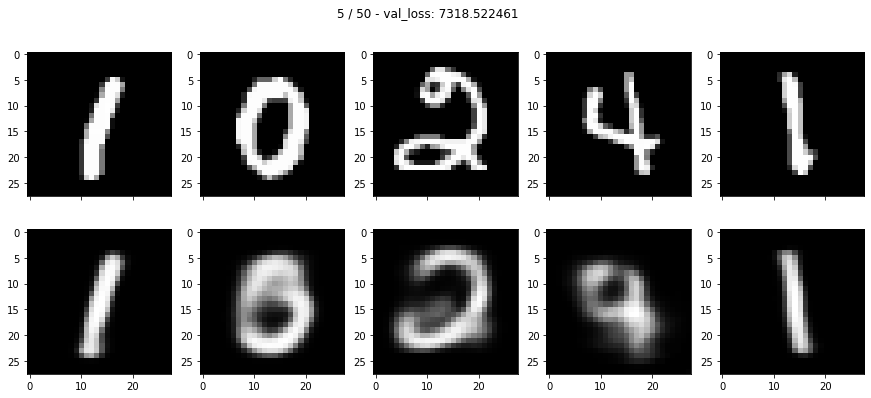

* Epoch 6/50
train loss: 9253.939453


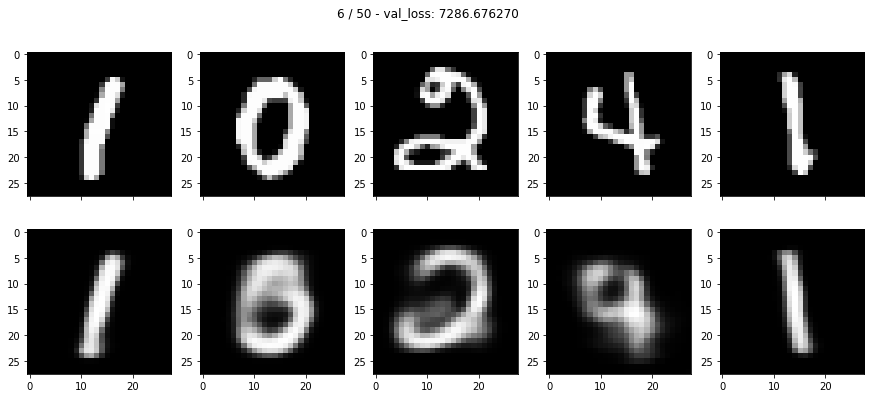

* Epoch 7/50
train loss: 9231.356445


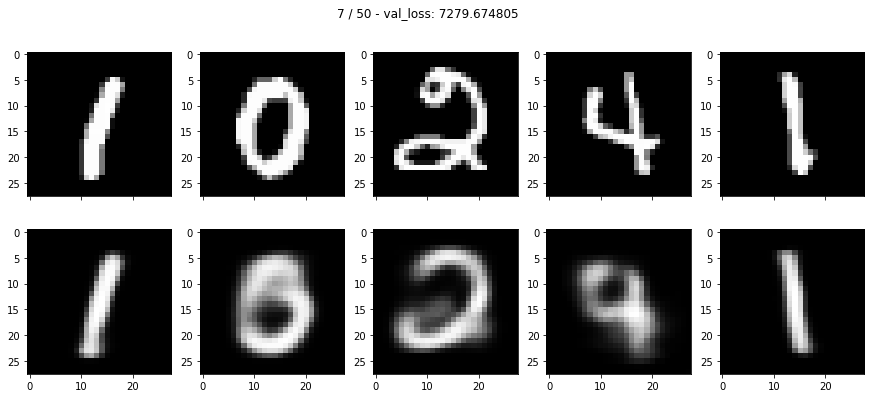

* Epoch 8/50
train loss: 9194.311523


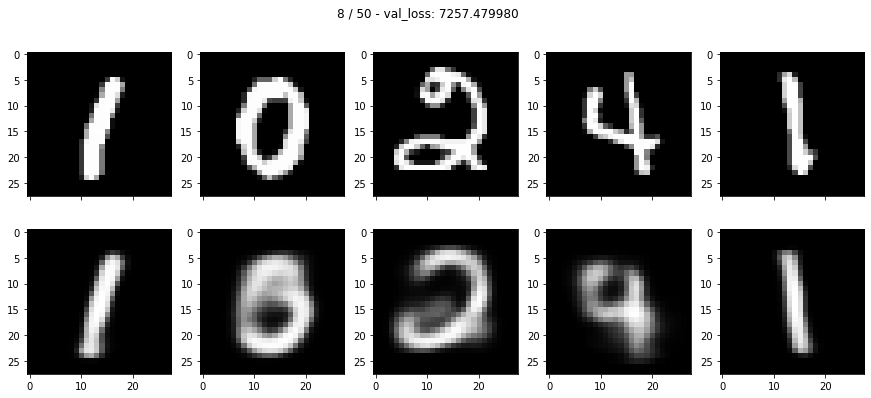

* Epoch 9/50
train loss: 9173.890625


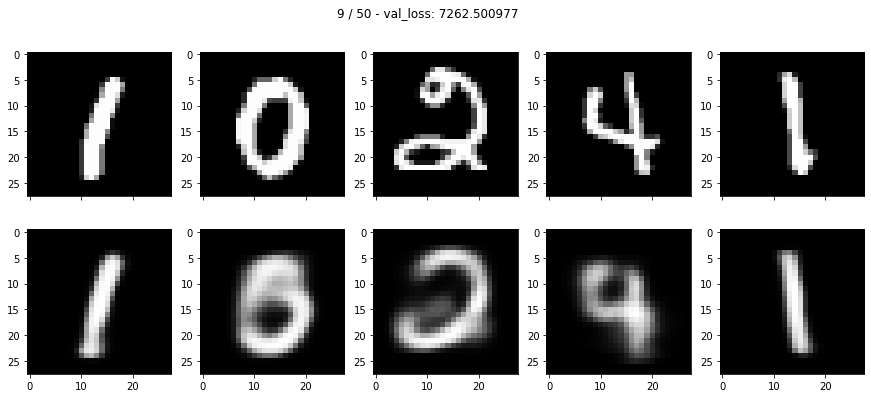

* Epoch 10/50
train loss: 9142.752930


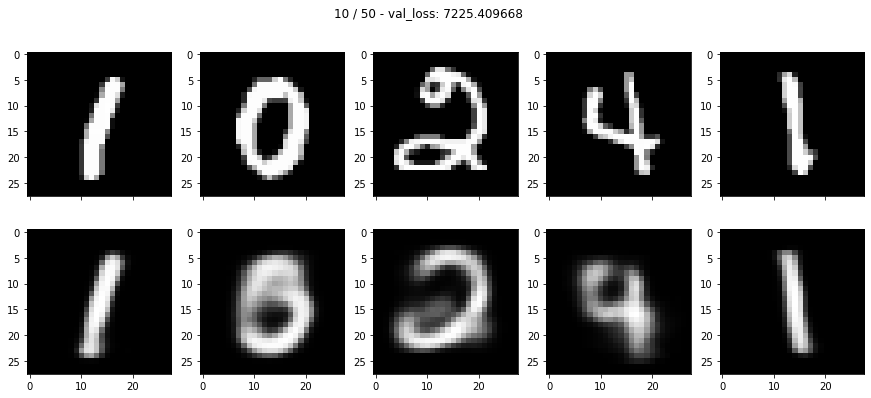

* Epoch 11/50
train loss: 9129.641602


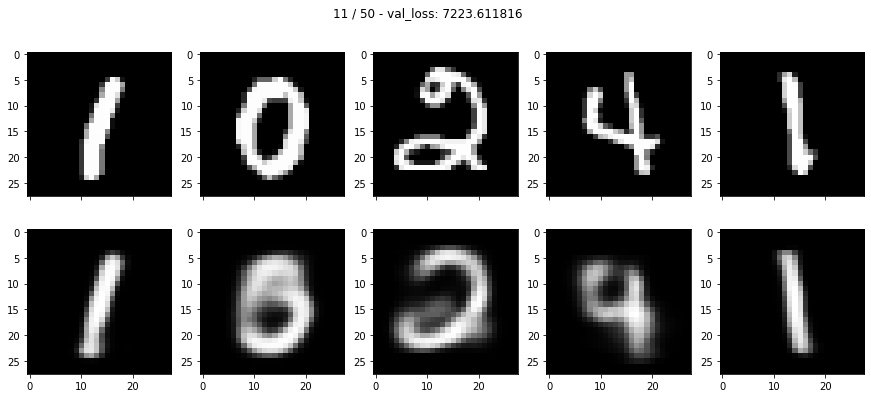

* Epoch 12/50
train loss: 9110.169922


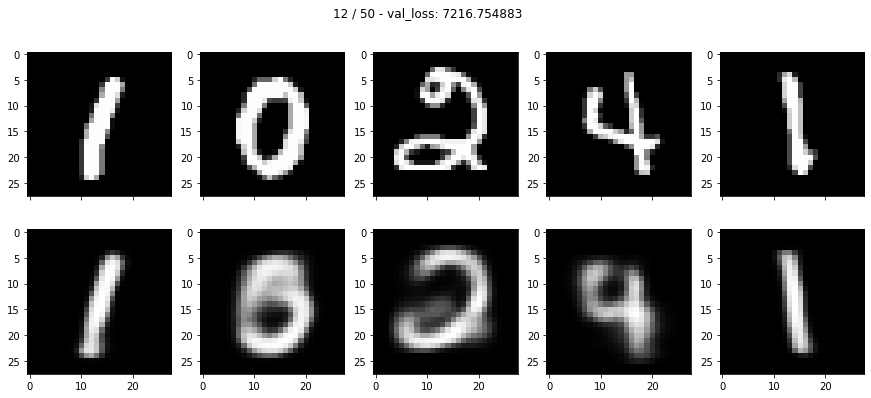

* Epoch 13/50
train loss: 9105.405273


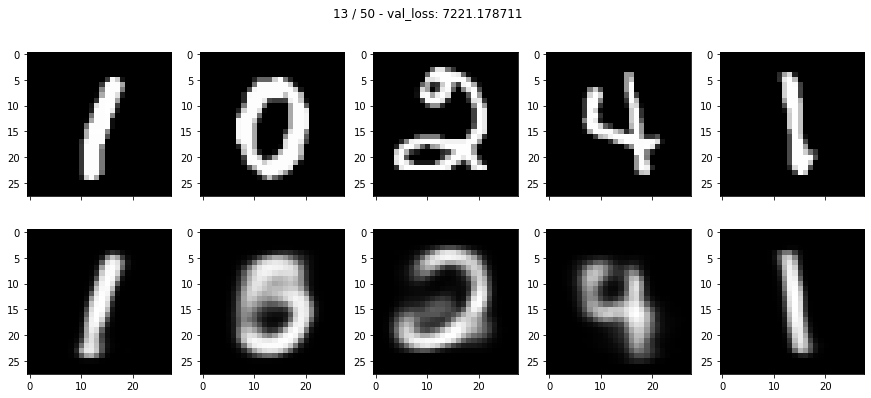

* Epoch 14/50
train loss: 9083.169922


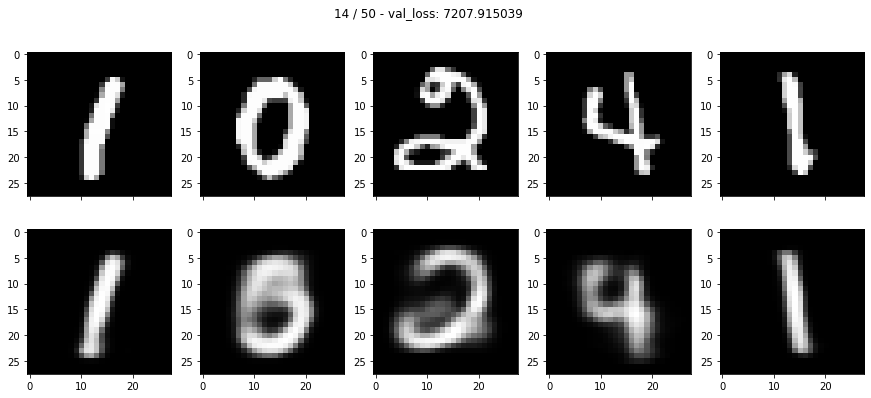

* Epoch 15/50
train loss: 9069.636719


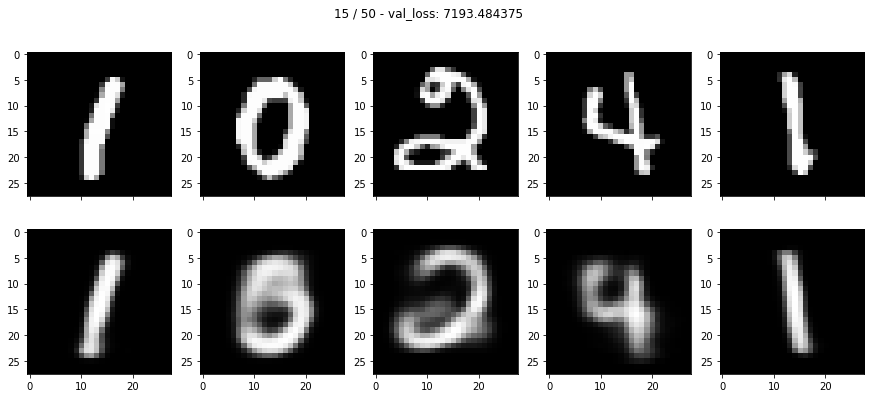

* Epoch 16/50
train loss: 9055.723633


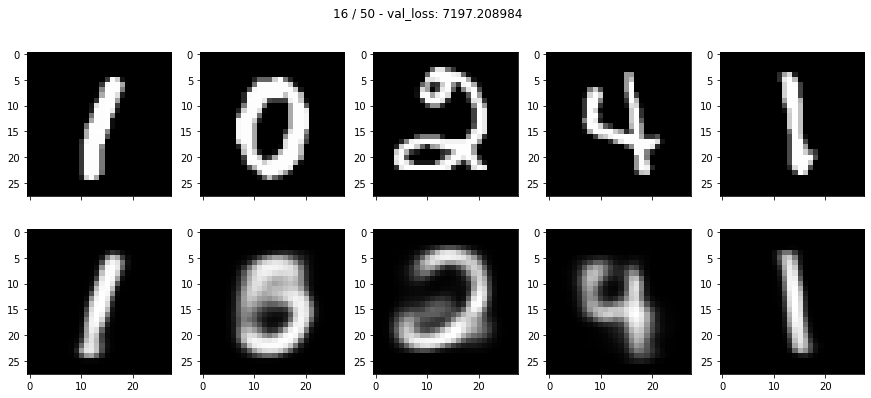

* Epoch 17/50
train loss: 9044.227539


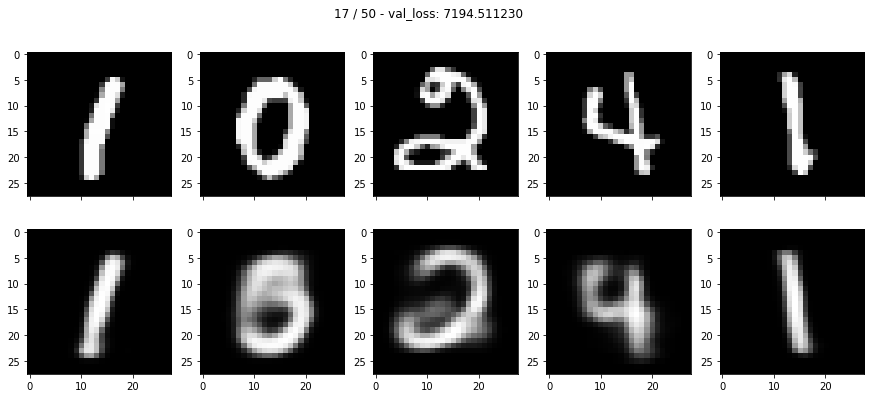

* Epoch 18/50
train loss: 9037.670898


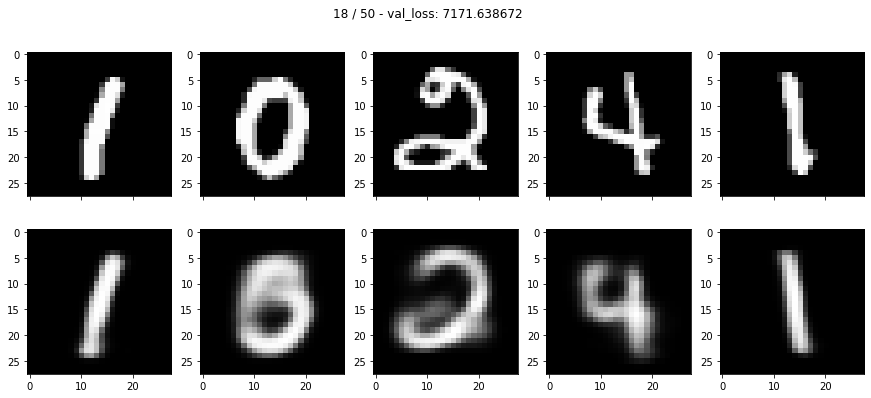

* Epoch 19/50
train loss: 9034.637695


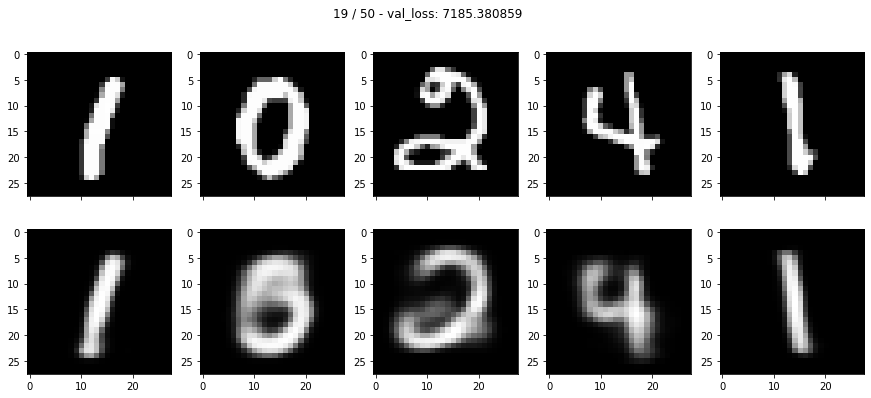

* Epoch 20/50
train loss: 9019.896484


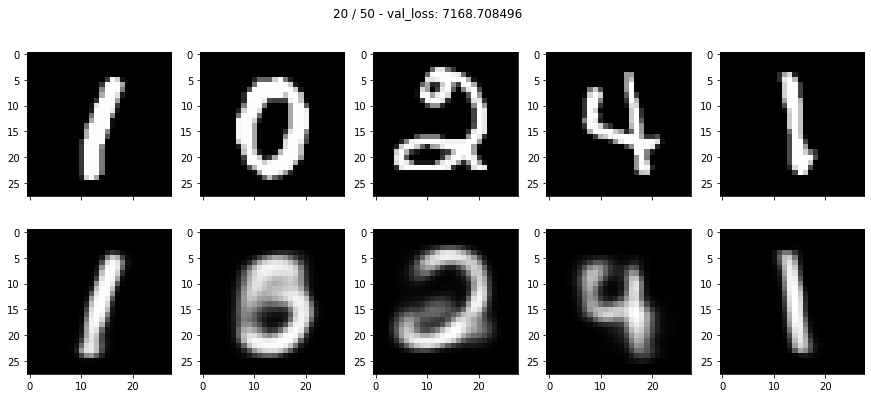

* Epoch 21/50
train loss: 9014.575195


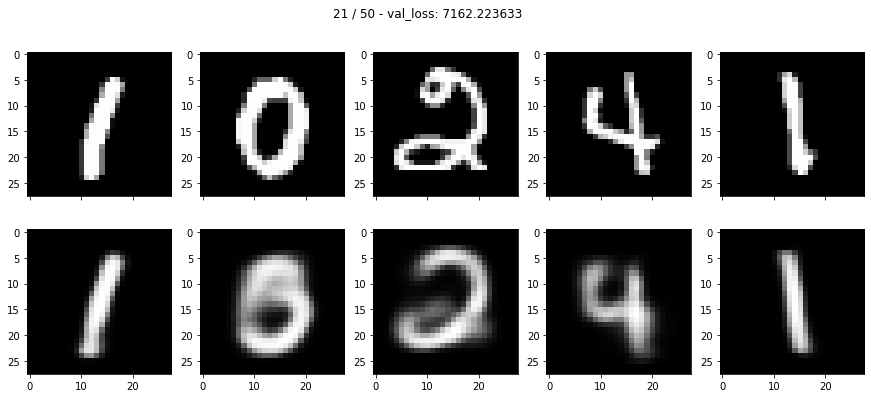

* Epoch 22/50
train loss: 8994.904297


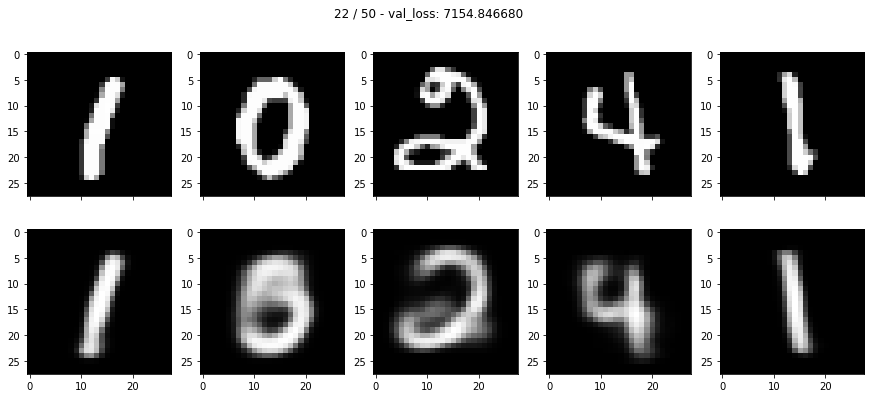

* Epoch 23/50
train loss: 8995.323242


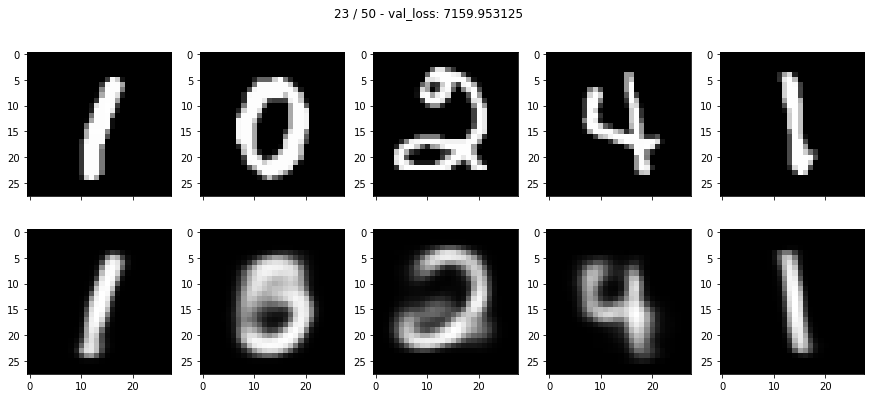

* Epoch 24/50
train loss: 8974.291992


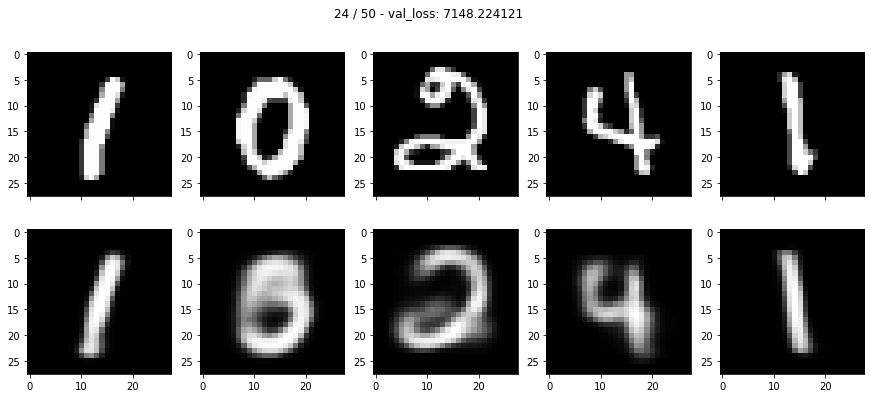

* Epoch 25/50
train loss: 8975.549805


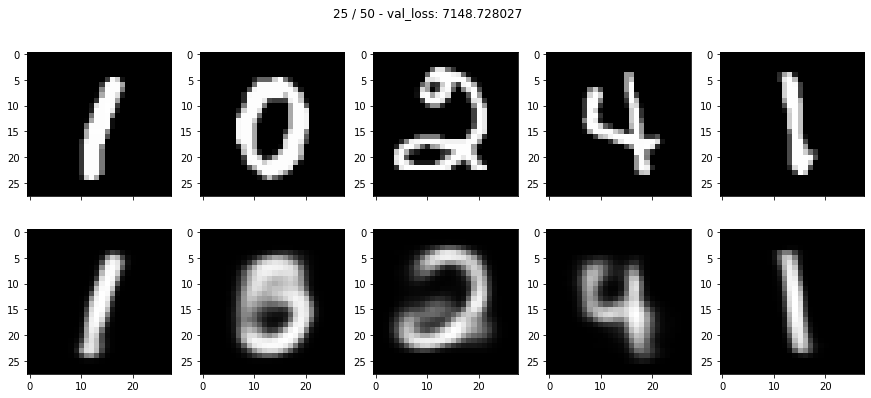

* Epoch 26/50
train loss: 8968.780273


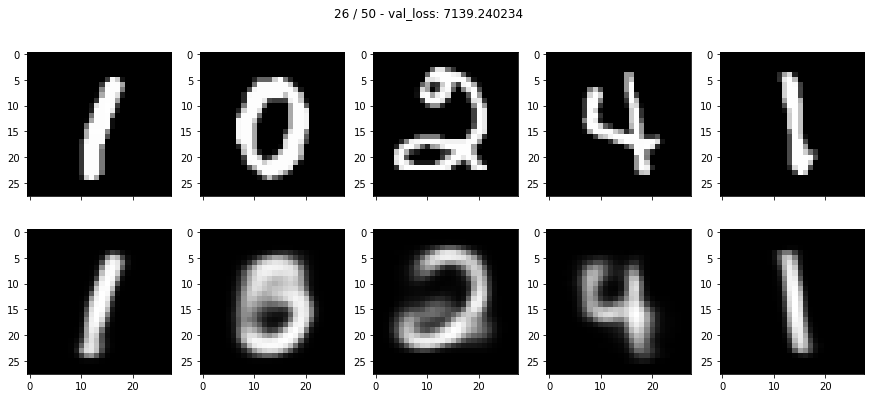

* Epoch 27/50
train loss: 8953.079102


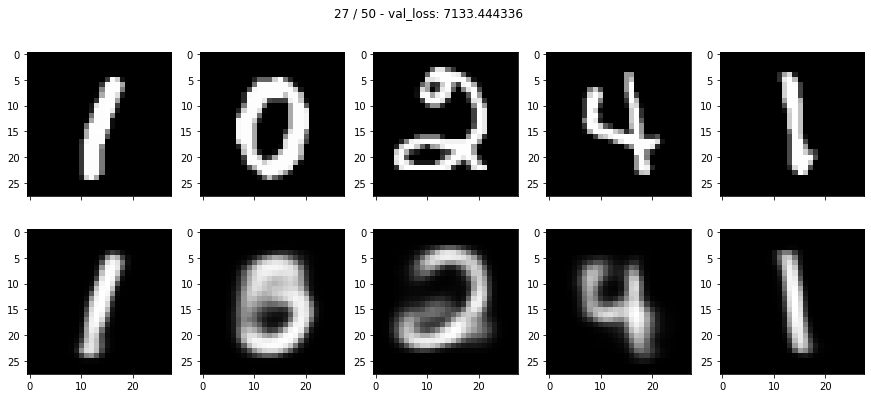

* Epoch 28/50
train loss: 8954.997070


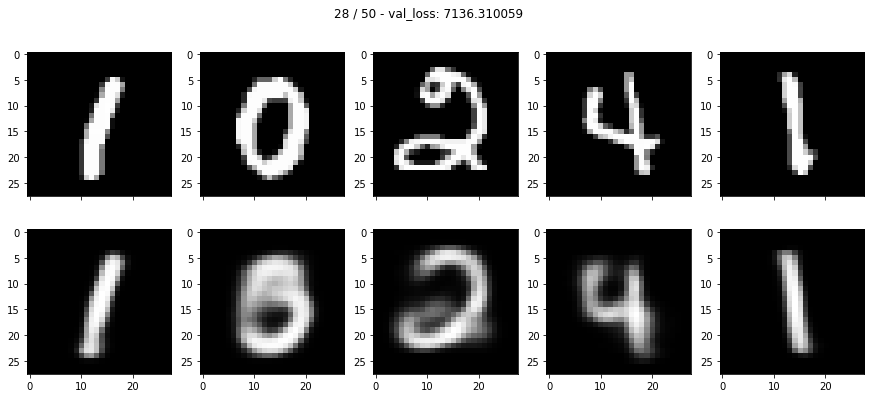

* Epoch 29/50
train loss: 8947.089844


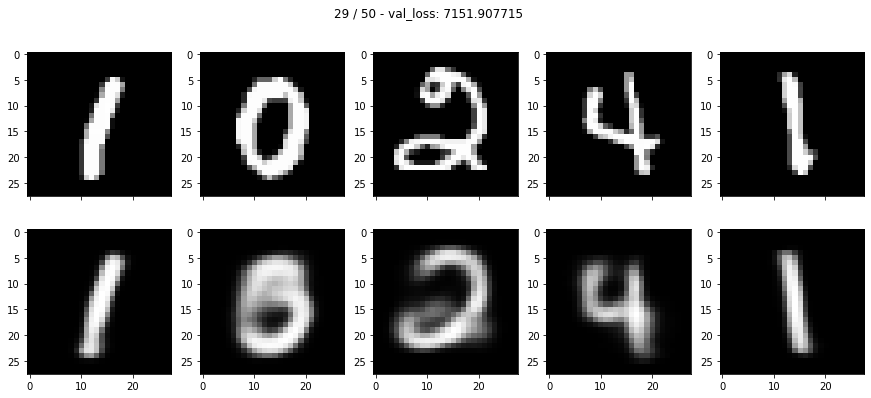

* Epoch 30/50
train loss: 8945.198242


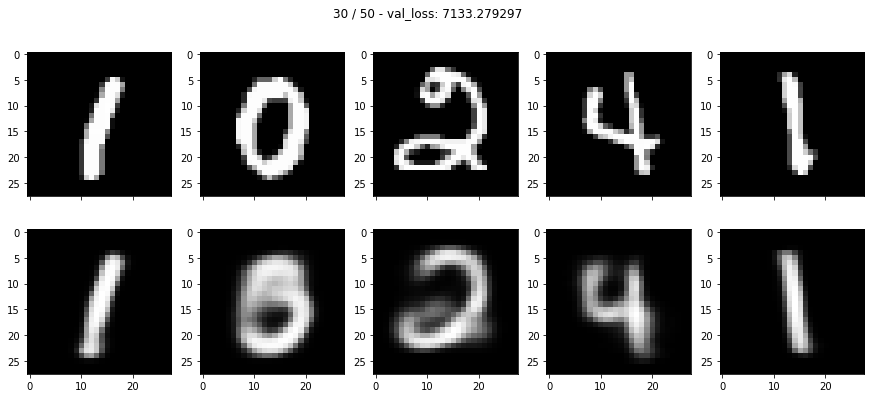

* Epoch 31/50
train loss: 8933.331055


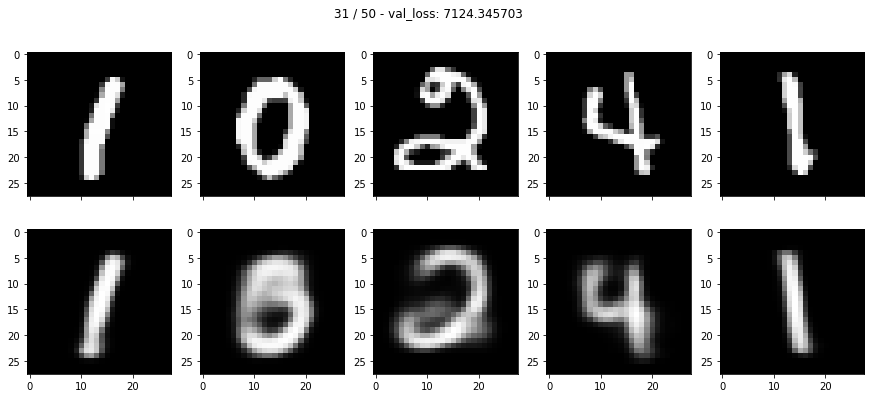

* Epoch 32/50
train loss: 8928.101562


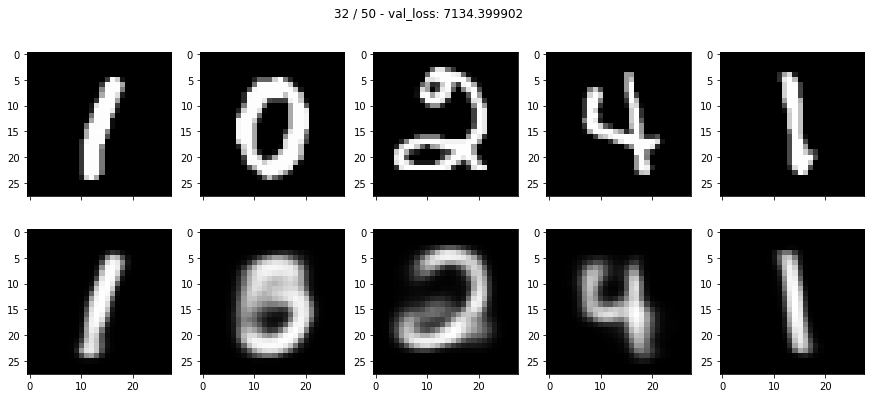

* Epoch 33/50
train loss: 8917.840820


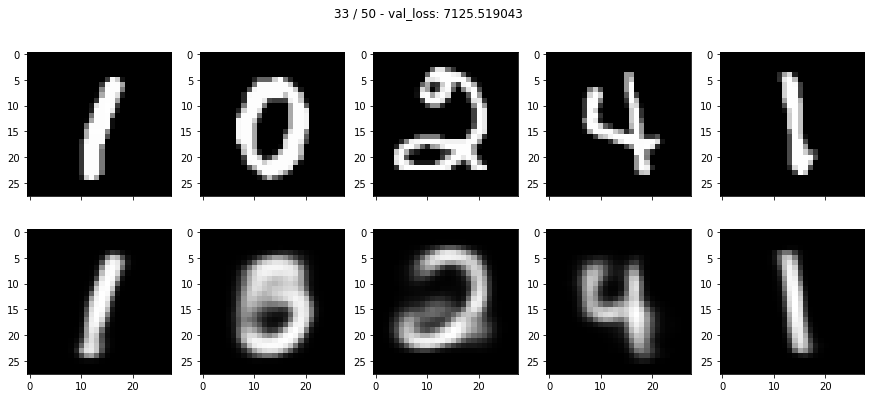

* Epoch 34/50
train loss: 8918.335938


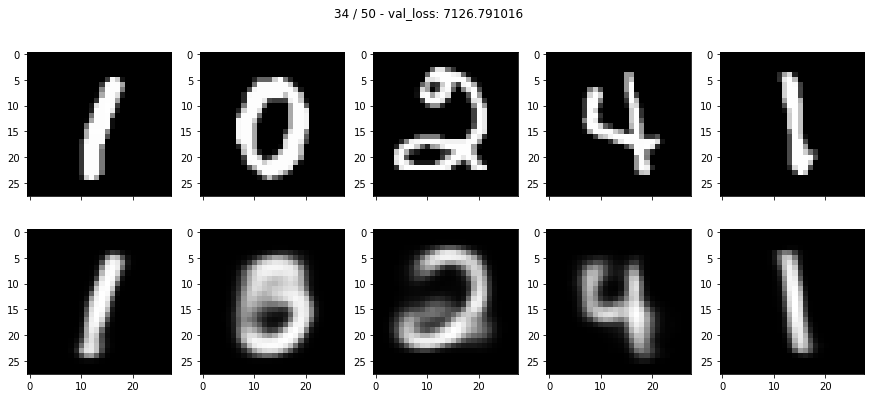

* Epoch 35/50
train loss: 8910.274414


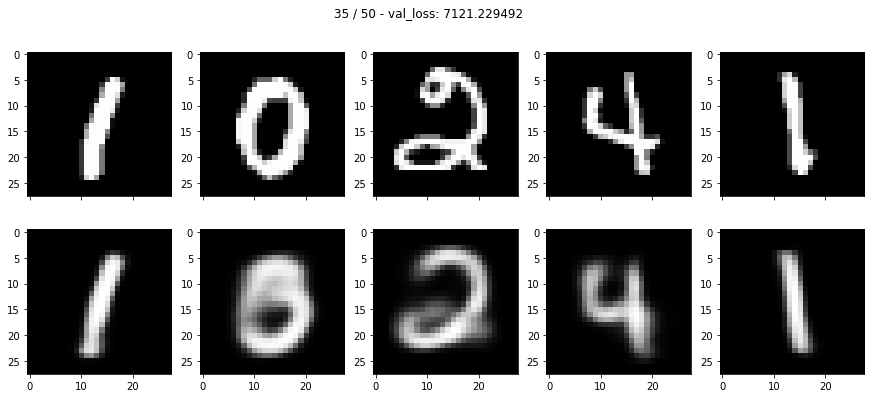

* Epoch 36/50
train loss: 8901.943359


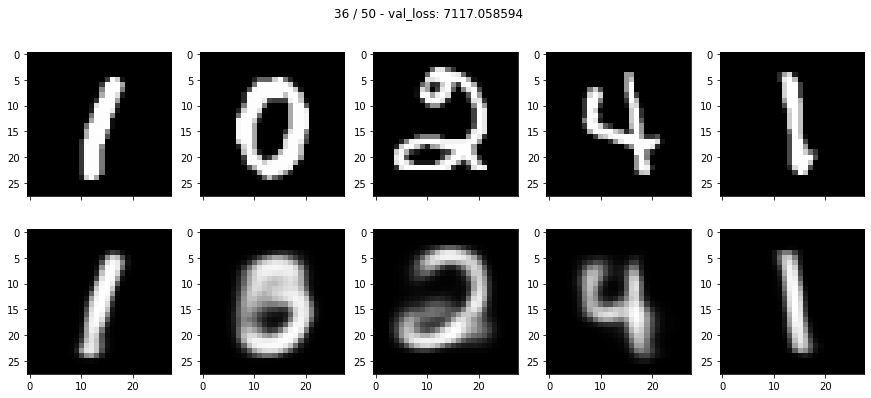

* Epoch 37/50
train loss: 8896.805664


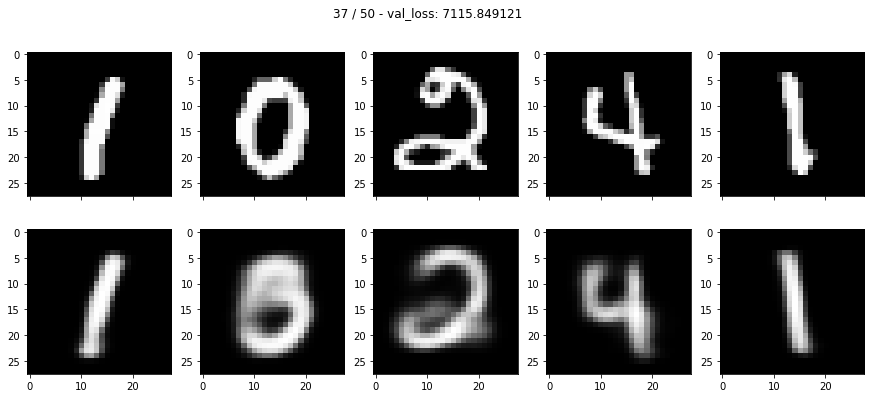

* Epoch 38/50
train loss: 8896.821289


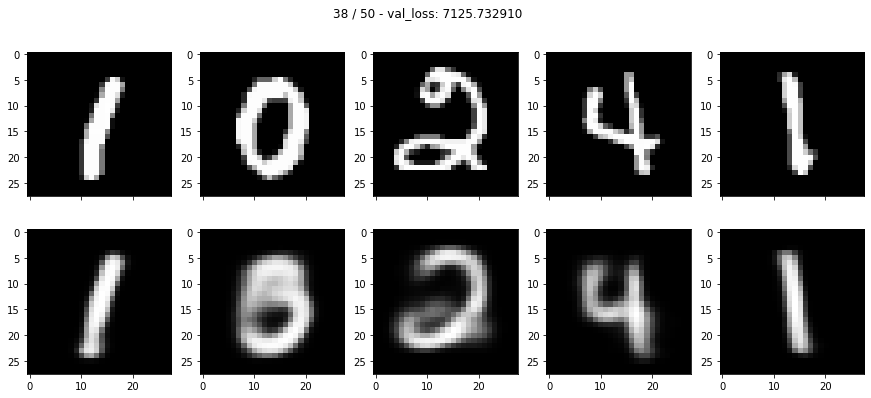

* Epoch 39/50
train loss: 8888.007812


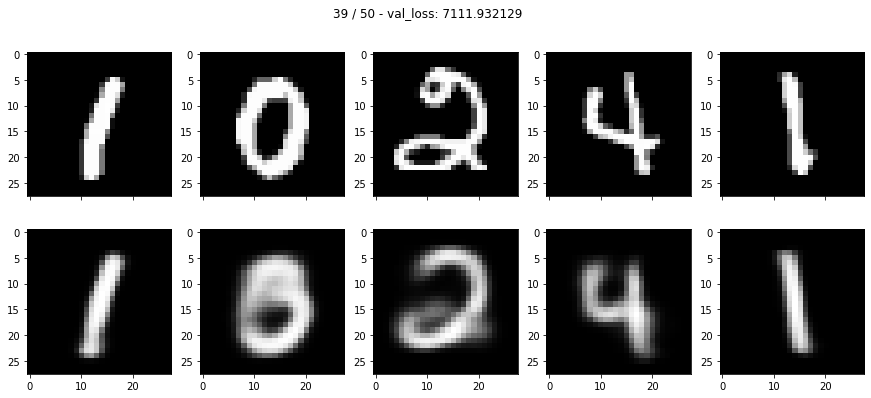

* Epoch 40/50
train loss: 8883.695312


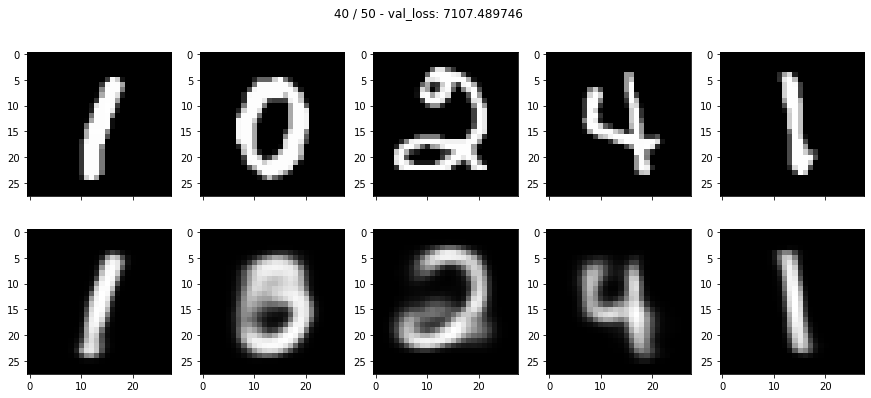

* Epoch 41/50
train loss: 8870.223633


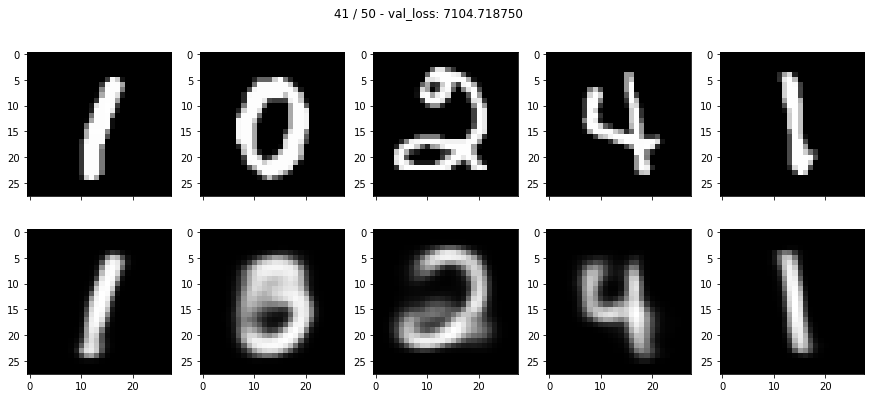

* Epoch 42/50
train loss: 8875.425781


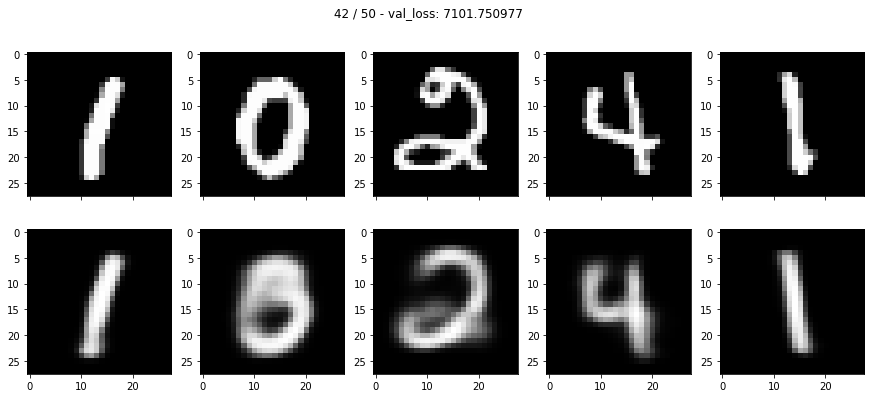

* Epoch 43/50
train loss: 8868.482422


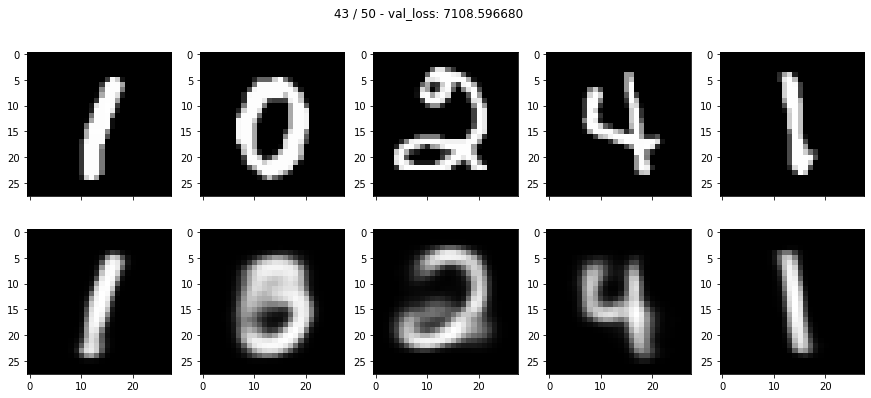

* Epoch 44/50
train loss: 8858.386719


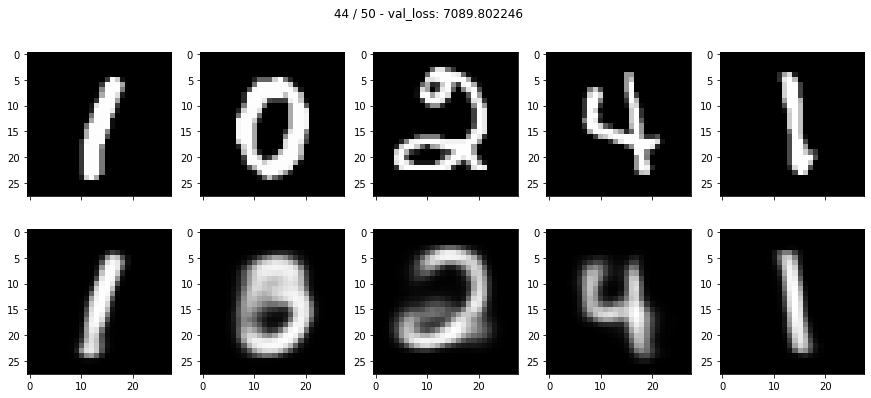

* Epoch 45/50
train loss: 8863.305664


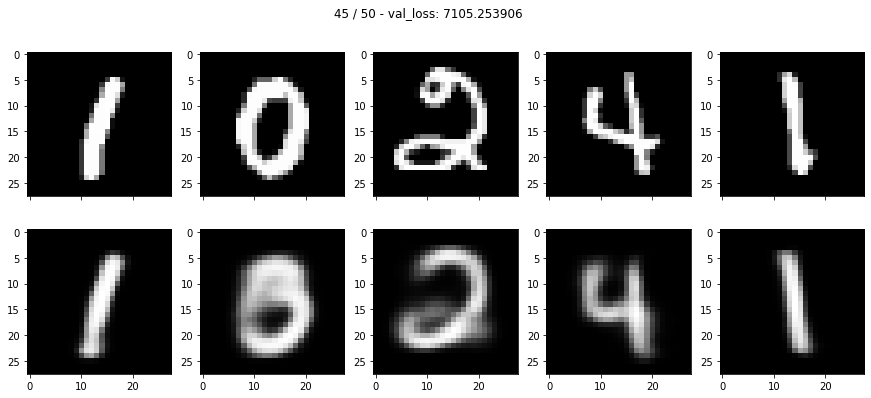

* Epoch 46/50
train loss: 8848.207031


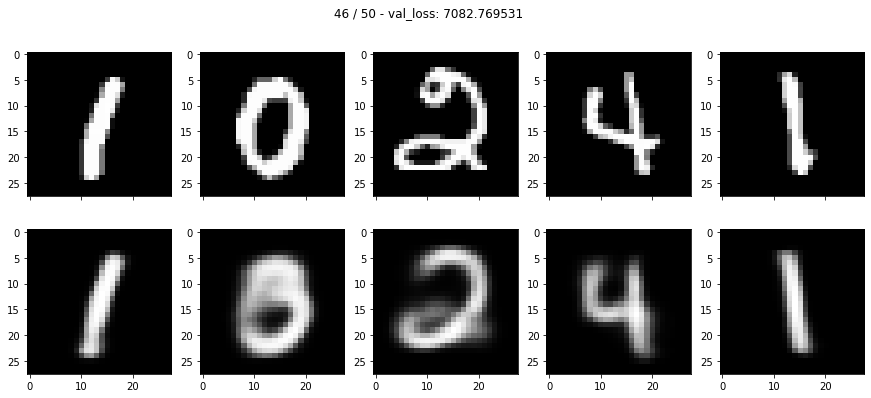

* Epoch 47/50
train loss: 8843.011719


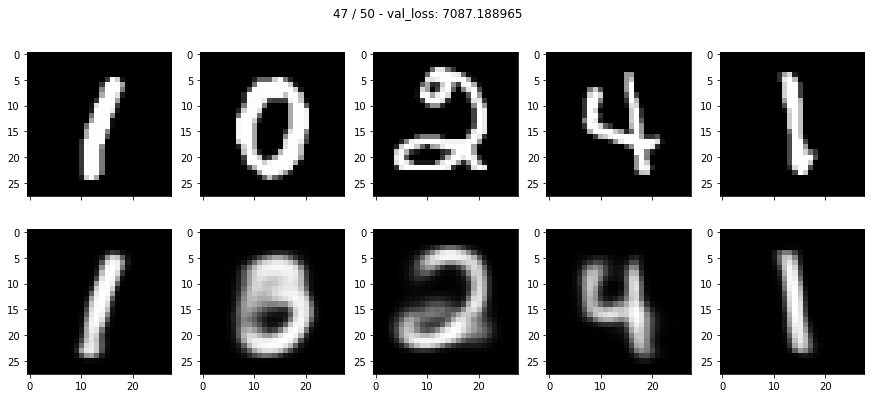

* Epoch 48/50
train loss: 8838.430664


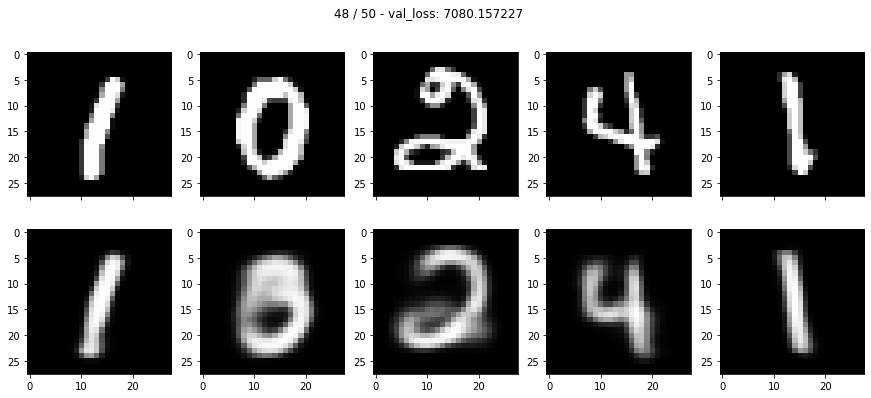

* Epoch 49/50
train loss: 8843.648438


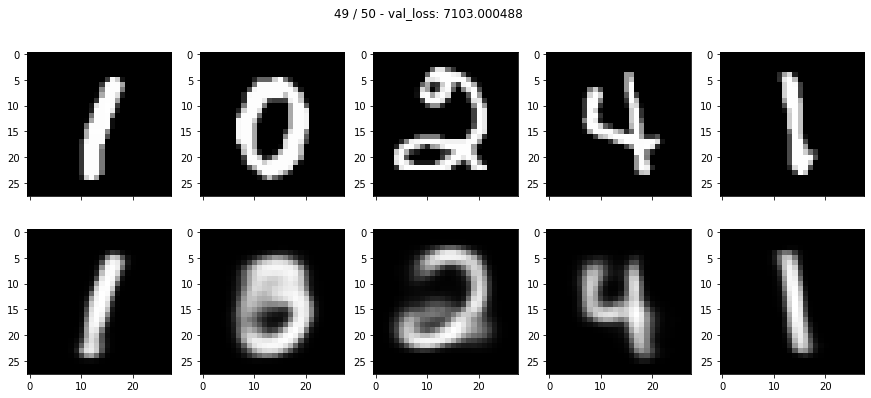

* Epoch 50/50
train loss: 8837.046875


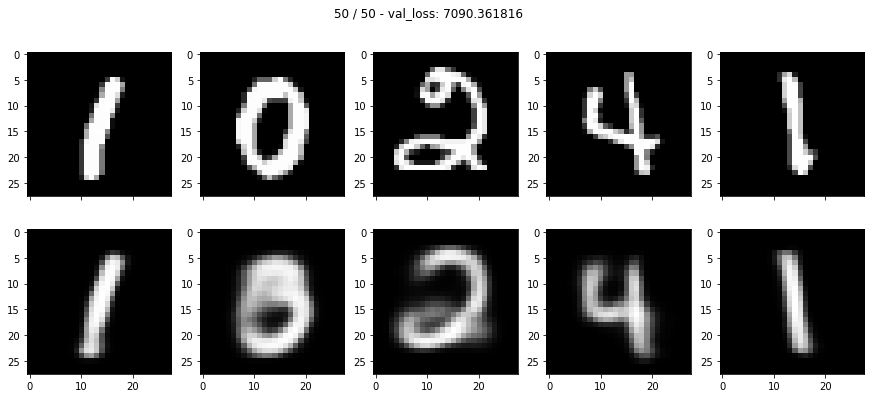

CPU times: user 4min 27s, sys: 4.69 s, total: 4min 32s
Wall time: 4min 31s


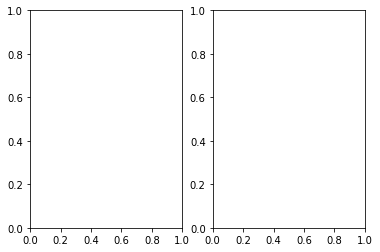

In [ ]:
%%time
train_loader = torch.utils.data.DataLoader(dataset=torch.cat((prev_X,X_train_45.to(device))), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.cat((X_test_01.to(device),
                                                             X_test_23.to(device),X_test_45.to(device))),
                                                              batch_size=batch_size, shuffle=True)
prev_len = len(torch.cat((prev_X,X_train_45.to(device))))
vae_train(autoencoder, optimizer, scheduler, 50, criterion, train_loader, test_loader)

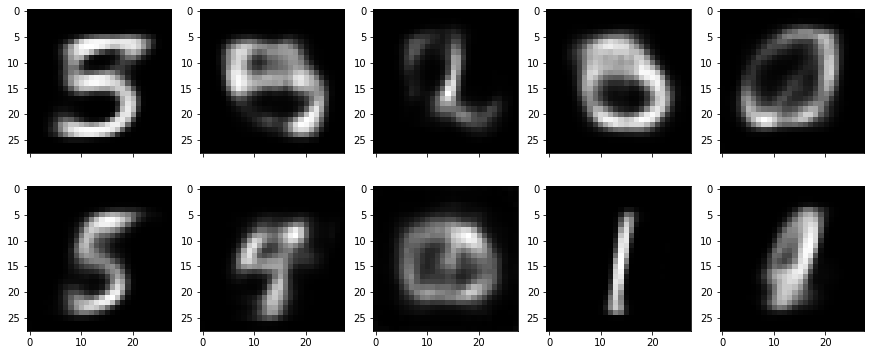

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([5, 3, 1, 0, 0, 3, 1, 0, 1, 2], device='cuda:0')
sum of 0 in generated samples: tensor(6971, device='cuda:0')
sum of 1 in generated samples: tensor(8516, device='cuda:0')
sum of 2 in generated samples: tensor(5484, device='cuda:0')
sum of 3 in generated samples: tensor(8892, device='cuda:0')
sum of 4 in generated samples: tensor(2758, device='cuda:0')
sum of 5 in generated samples: tensor(3396, device='cuda:0')


In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(prev_len)])
autoencoder.eval()
with torch.set_grad_enabled(False):
    output = autoencoder.decode(torch.Tensor(z).to(device))

fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(output[j].squeeze().cpu(), cmap ='gray')

for j in range(5):
    ax[1][j].imshow(output[j+5].cpu().squeeze(), cmap = 'gray')
plt.show()

prev_X = output
prev_y = lenet(output).argmax(dim=1)
print(prev_y[:10])

for i in range(max(prev_y+1)):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

In [ ]:
new_X_train = torch.cat((prev_X, X_train_67.to(device)))
new_y_train = torch.cat((prev_y, y_train_67.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_45.to(device)))
prev_y_test = torch.cat((prev_y_test, y_test_45.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_67.to(device)))
cur_y_test = torch.cat((prev_y_test, y_test_67.to(device)))
my_ewc = EWC(prev_X, prev_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
%%time
ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=4, ewc=my_ewc, importance=5e5, epochs=10) #обучаем классификатор на 01234567

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy on current task:  tensor(0.7493)
accuracy on old task:  tensor(0.8567)
accuracy on 01:  tensor(0.7097)
accuracy on 23:  tensor(0.8521)
accuracy on 45:  tensor(0.8911)
accuracy on 67:  tensor(0.4366)
accuracy on current task:  tensor(0.8028)
accuracy on old task:  tensor(0.8042)
accuracy on 01:  tensor(0.6619)
accuracy on 23:  tensor(0.8301)
accuracy on 45:  tensor(0.7769)
accuracy on 67:  tensor(0.8177)
accuracy on current task:  tensor(0.8285)
accuracy on old task:  tensor(0.8206)
accuracy on 01:  tensor(0.7002)
accuracy on 23:  tensor(0.8071)
accuracy on 45:  tensor(0.8351)
accuracy on 67:  tensor(0.8580)
accuracy on current task:  tensor(0.8261)
accuracy on old task:  tensor(0.8030)
accuracy on 01:  tensor(0.6766)
accuracy on 23:  tensor(0.7806)
accuracy on 45:  tensor(0.8671)
accuracy on 67:  tensor(0.8842)
accuracy on current task:  tensor(0.8240)
accuracy on old task:  tensor(0.8073)
accuracy on 01:  tensor(0.6960)
accuracy on 23:  tensor(0.7272)
accuracy on 45:  tensor(

In [ ]:
%%time
train_loader = torch.utils.data.DataLoader(dataset=torch.cat((prev_X,X_train_67.to(device))), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=torch.cat((X_test_01.to(device),
                                                             X_test_23.to(device),X_test_45.to(device),X_test_67.to(device))),
                                                              batch_size=batch_size, shuffle=True)
prev_len = len(torch.cat((prev_X,X_train_67.to(device))))
print(prev_len)
vae_train(autoencoder, optimizer, scheduler, 50, criterion, train_loader, test_loader)

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(prev_len)])
autoencoder.eval()
with torch.set_grad_enabled(False):
    output = autoencoder.decode(torch.Tensor(z).to(device))

fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(output[j].squeeze().cpu(), cmap ='gray')

for j in range(5):
    ax[1][j].imshow(output[j+5].cpu().squeeze(), cmap = 'gray')
plt.show()

prev_X = output
prev_y = lenet(output).argmax(dim=1)
print(prev_y[:10])

for i in range(max(prev_y+1)):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

In [ ]:
new_X_train = torch.cat((prev_X, X_train_89.to(device)))
new_y_train = torch.cat((prev_y, y_train_89.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_67.to(device)))
prev_y_test = torch.cat((prev_y_test, y_test_67.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_89.to(device)))
cur_y_test = torch.cat((prev_y_test, y_test_89.to(device)))
my_ewc = EWC(prev_X, prev_y)

In [ ]:
%%time
ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=5, ewc=my_ewc, importance=5e5, epochs=10) #обучаем классификатор на 0123456789

In [ ]:
test_accuracy(X_test,y_test)